### ANALYZE RESULTS
Ferri - create an folder called 'results' in your os.getcwd(). In it create folder for each experiment ('mgmt_with_normal_cot',...). Each experiment folder should contains csvs in the format of {lang}.csv.


see running example below

### Data Reading

In [239]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import matplotlib

ALL_LANGUAGES = ['en', 'es', 'fr', 'de', 'ru', 'zh', 'ja', 'th', 'sw', 'bn', 'te']
UNDERREPRESENTED_LANGUAGES = ['te','th','bn']
MODERATLY_LANGUAGES = ['es', 'fr', 'de', 'ru', 'zh', 'ja']
def read_folder(folder_path, accepted_languages = ('en', 'es', 'fr', 'de', 'ru', 'zh', 'ja', 'th', 'sw', 'bn', 'te')):
    "this function assume folder with files in the format of {language}.csv"
    dataframes = dict()
    for file in os.listdir(folder_path):
        lang = file.split('.')[0]
        if lang not in accepted_languages:
            print(f'The file {file} is not in the right format of {{language}}.csv or is not known language, continue to the next files')
            continue
        dataframes[lang] = pd.read_csv(os.path.join(folder_path, file))
    print(f'Load files for the languages: {list(dataframes.keys())}')
    return dataframes

def analyze_results(results_dataframe):
    'this function assumes pandas dataframe with "model correct" column.'
    return np.round(results_dataframe['model correct'].sum()/len(results_dataframe), decimals=4)

def analyze_multiple_dataframes(dict_of_dicts_of_dfs):
    'this function assumes dict of the format of {experiment name: langs_df_dict}, where langs_df_dict is dict of the format of {lang: df}'
    results_df = pd.DataFrame()
    for experiment_name, langs_df_dict in dict_of_dicts_of_dfs.items():
        for lang, df in langs_df_dict.items():
            results_df.loc[experiment_name,lang] = analyze_results(df)
    results_df['average'] = results_df.mean(axis = 1)
    results_df['highly_underrepresented_average'] = results_df[[col for col in results_df.columns if col in UNDERREPRESENTED_LANGUAGES]].mean(axis = 1)
    results_df['moderately_underrepresented_average'] = results_df[[col for col in results_df.columns if col in MODERATLY_LANGUAGES]].mean(axis = 1)

    results_df.loc['Language Average',:] = results_df.mean(axis = 0)
    return results_df

def get_color(index, N, color_map = 'tab10'):
    colors = plt.get_cmap(color_map)
    return colors(index % N)
    
def get_encoder(model = "gpt-3.5-turbo-0613"):
    return tiktoken.encoding_for_model(model)

def get_tokens_number(text, enc):
    if pd.isnull(text):
        return 0
    else:
        return len(enc.encode(text))

def count_tokens_multiple_dataframes(dict_of_dicts_of_dfs,model = 'gpt-3.5-turbo-0613'):
    'this function assumes dict of the format of {experiment name: langs_df_dict}, where langs_df_dict is dict of the format of {lang: df}'
    model_prompts_results = pd.DataFrame()
    system_prompts_results = pd.DataFrame()
    enc = get_encoder(model = model)
    for experiment_name, langs_df_dict in dict_of_dicts_of_dfs.items():
        for lang, df in langs_df_dict.items():
            model_prompts_results.loc[experiment_name, lang] = df['model_answer'].apply(lambda row: get_tokens_number(row,enc)).mean()
            system_prompts_results.loc[experiment_name, lang] = df['system_prompt'].apply(lambda row: get_tokens_number(row,enc)).mean()
    model_prompts_results['average'] = model_prompts_results.mean(axis = 1)
    model_prompts_results['highly_underrepresented_average'] = model_prompts_results[[col for col in model_prompts_results.columns if col in UNDERREPRESENTED_LANGUAGES]].mean(axis = 1)
    model_prompts_results['moderately_underrepresented_average'] = model_prompts_results[[col for col in model_prompts_results.columns if col in MODERATLY_LANGUAGES]].mean(axis = 1)

    system_prompts_results['average'] = system_prompts_results[[col for col in system_prompts_results.columns if col != 'en']].mean(axis = 1)
    system_prompts_results['highly_underrepresented_average'] = system_prompts_results[[col for col in system_prompts_results.columns if col in UNDERREPRESENTED_LANGUAGES]].mean(axis = 1)
    system_prompts_results['moderately_underrepresented_average'] = system_prompts_results[[col for col in system_prompts_results.columns if col in MODERATLY_LANGUAGES]].mean(axis = 1)

    model_prompts_results.loc['average',:] = model_prompts_results.mean(axis = 0)
    system_prompts_results.loc['average',:] = system_prompts_results.mean(axis = 0)

    return model_prompts_results, system_prompts_results

def fill_missing_scores(results,after_rename = True):
    if after_rename:
        results.loc[rename_row_dict['mgmt_cot_in_english'],'English'] = results.loc[rename_row_dict['mgmt_with_normal_cot'],'English']
        results.loc[rename_row_dict['mgmt_4o_translate_with_cot'],'English'] = results.loc[rename_row_dict['mgmt_4o_regular_cot'],'English']
        results.loc[rename_row_dict['mgmt_translate_with_cot'],'English'] = results.loc[rename_row_dict['mgmt_with_normal_cot'],'English']
        results.loc[rename_row_dict['mgmt_translate_without_cot'],'English'] = results.loc[rename_row_dict['mgmt_without_cot'],'English']
        
        results.loc[rename_row_dict['mgmt_two_language_input_cot_in_original_language'],'English'] = results.loc[rename_row_dict['mgmt_two_language_input_cot_in_english'],'English']
        results.loc[rename_row_dict['mgmt_english_input_cot_in_original_language'],'English'] = results.loc[rename_row_dict['mgmt_two_language_input_cot_in_english'],'English']
        results['Total Average'] = results.mean(axis = 1)
    else:
        results.loc['mgmt_cot_in_english','en'] = results.loc['mgmt_with_normal_cot','en']
        results.loc['mgmt_4o_translate_with_cot','en'] = results.loc['mgmt_4o_regular_cot','en']
        results.loc['mgmt_translate_with_cot','en'] = results.loc['mgmt_with_normal_cot','en']
        results.loc['mgmt_translate_without_cot','en'] = results.loc['mgmt_without_cot','en']
        
        results.loc['mgmt_two_language_input_cot_in_original_language','en'] = results.loc['mgmt_two_language_input_cot_in_english','en']
        results.loc['mgmt_english_input_cot_in_original_language','en'] = results.loc['mgmt_two_language_input_cot_in_english','en']
        results['average'] = results.mean(axis = 1)
    return results
def default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL):
    matplotlib.rcParams.update({'font.size': FONT_SIZE})
    x = np.arange(len(LANGUAGE_TO_PLOT))  # the label locations
    width = 0.97  # the width of the bars
    
    fig, ax = plt.subplots(figsize=FIG_SIZE,dpi = RES)
    
    for idx_exp, exp in enumerate(EXP_TO_PLOT):
        exp_data = results.loc[exp,LANGUAGE_TO_PLOT].values
        for i, lang in enumerate(LANGUAGE_TO_PLOT):
            if lang in COLS_TO_BOLD:
                ax.plot([x[i] - width/2, x[i] + width/2], [exp_data[i], exp_data[i]], color=get_color(idx_exp,len(EXP_TO_PLOT)), linewidth=2.5, label= EXP_NAMES_TO_SHOW[idx_exp] if i == 0 else "")
                if not (lang,exp) in DROP_RESULT_FOR_VISUAL:
                    ax.text(x[i], exp_data[i], f'{exp_data[i]:.2}', color='black', va='bottom', ha='center',fontweight='bold') 
            else:
                ax.plot([x[i] - width/2, x[i] + width/2], [exp_data[i], exp_data[i]], color=get_color(idx_exp,len(EXP_TO_PLOT)), linewidth=2, label= EXP_NAMES_TO_SHOW[idx_exp] if i == 0 else "")
                if not (lang,exp) in DROP_RESULT_FOR_VISUAL:
                    ax.text(x[i], exp_data[i], f'{exp_data[i]:.2}', color='black', va='bottom', ha='center')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylim(*Y_LIM)
    ax.set_xlabel('Languages and groups',fontweight = 'bold')
    ax.set_ylabel('Success Rate',fontweight = 'bold')
    # ax.set_title(f'{FIG_NAME}')
    ax.set_xticks(x)
    ax.xaxis.set_tick_params(labelsize=FONT_SIZE)
    ax.set_xticklabels(X_TICKS)
    ax.legend()
    fig.tight_layout()
    if SAVE_PATH:
        plt.savefig(SAVE_PATH,dpi = RES)
    plt.show()

In [228]:
pd.options.display.float_format = "{:,.4f}".format

# experiment to compare (folders in 'results' folder)
db_exp_names  = ['mgmt_without_cot', 'mgmt_with_normal_cot', 'mgmt_cot_in_english', 'mgmt_english_input_cot_in_original_language', 'mgmt_two_language_input_cot_in_english', 'mgmt_two_language_input_cot_in_original_language', 'mgmt_translate_without_cot', 'mgmt_translate_with_cot', 'mgmt_4o_no_preprompt', 'mgmt_4o_regular_cot', 'mgmt_4o_translate_with_cot']
new_exp_names = ['(Forced) No COT','Column Language Question - Column Language CoT','Column Language Question - English CoT','English Question - Column Language CoT','Question in both languages - English CoT','Question in both languages - Column Language CoT','Translate without CoT Premise','L-COT','No Premise (GPT-4o)','Regular CoT Premise (GPT-4o)','L-COT (GPT-4o)']
old_col_names = ['es', 'de', 'ru', 'fr', 'zh', 'sw', 'ja', 'th', 'bn', 'te','en','moderately_underrepresented_average','highly_underrepresented_average','average']
new_col_names  = ['es', 'de', 'ru', 'fr', 'zh', 'sw', 'ja', 'th', 'bn', 'te','English',r'Group B Average',r'Group C Average',r'Total Average']

rename_row_dict = {f_name: n_name for f_name,n_name in zip(db_exp_names,new_exp_names)}
rename_col_dict = {f_name: n_name for f_name,n_name in zip(old_col_names,new_col_names)}

# use read_folder function to read all the results
results_dfs = {experiment_name: read_folder(f'results/{experiment_name}') for experiment_name in db_exp_names}

# run comparison
results = analyze_multiple_dataframes(results_dfs)
results = fill_missing_scores(results,after_rename = False)

results = results.rename(index = rename_row_dict).rename(columns = rename_col_dict).loc[new_exp_names,new_col_names] # renaming and reordering
# results.to_latex() Intersting option to move it to latex
results

Load files for the languages: ['bn', 'de', 'en', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'en', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'en', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
The file .ipynb_checkpoints is not in the right format of {language}.csv or is not known language, continue to the next files
Load files for the languages: ['bn', 'de', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: ['bn', 'de', 'en', 'es', 'fr', 'ja', 'ru', 'sw', 'te', 'th', 'zh']
Load files for the languages: [

es     de     ru     fr  \
(Forced) No COT                                  0.3240 0.3160 0.3680 0.3160   
Column Language Question - Column Language CoT   0.7200 0.6760 0.6720 0.6640   
Column Language Question - English CoT           0.7680 0.7120 0.7640 0.7400   
English Question - Column Language CoT           0.7760 0.7320 0.7240 0.7600   
Question in both languages - English CoT         0.7560 0.7680 0.7480 0.7800   
Question in both languages - Column Language CoT 0.7600 0.7280 0.7240 0.7000   
Translate without CoT Premise                    0.3160 0.3240 0.3560 0.3280   
L-COT                                            0.7640 0.7360 0.7880 0.7480   
No Premise (GPT-4o)                              0.7880 0.8000 0.8120 0.7400   
Regular CoT Premise (GPT-4o)                     0.8680 0.8440 0.8760 0.8120   
L-COT (GPT-4o)                                   0.9360 0.9160 0.9520 0.9000   

                                                     zh     sw     ja     th  \
(Forced) No COT                                  0.3080 0.2720 0.2800 0.2840   
Column Language Question - Column Language CoT   0.6320 0.5400 0.5320 0.4080   
Column Language Question - English CoT           0.6440 0.6600 0.6040 0.5520   
English Question - Column Language CoT           0.7400 0.7440 0.6880 0.6280   
Question in both languages - English CoT         0.7400 0.7760 0.7560 0.7480   
Question in both languages - Column Language CoT 0.7080 0.7040 0.6480 0.6440   
Translate without CoT Premise                    0.3320 0.2960 0.3120 0.2920   
L-COT                                            0.7280 0.7200 0.7000 0.6160   
No Premise (GPT-4o)                              0.8680 0.7560 0.8760 0.8360   
Regular CoT Premise (GPT-4o)                     0.8960 0.8880 0.8680 0.9240   
L-COT (GPT-4o)                                   0.9200 0.9120 0.8960 0.9240   

                                                     bn     te  English  \
(Forced) No COT                                  0.1960 0.0920   0.3600   
Column Language Question - Column Language CoT   0.3000 0.1480   0.8000   
Column Language Question - English CoT           0.4040 0.2640   0.8000   
English Question - Column Language CoT           0.4400 0.2560   0.7760   
Question in both languages - English CoT         0.7280 0.7240   0.7760   
Question in both languages - Column Language CoT 0.4880 0.2120   0.7760   
Translate without CoT Premise                    0.2800 0.1680   0.3600   
L-COT                                            0.6320 0.3840   0.8000   
No Premise (GPT-4o)                              0.8840 0.8680   0.8720   
Regular CoT Premise (GPT-4o)                     0.9120 0.8640   0.9520   
L-COT (GPT-4o)                                   0.9120 0.8880   0.9520   

                                                  Group B Average  \
(Forced) No COT                                            0.3187   
Column Language Question - Column Language CoT             0.6493   
Column Language Question - English CoT                     0.7053   
English Question - Column Language CoT                     0.7367   
Question in both languages - English CoT                   0.7580   
Question in both languages - Column Language CoT           0.7113   
Translate without CoT Premise                              0.3280   
L-COT                                                      0.7440   
No Premise (GPT-4o)                                        0.8140   
Regular CoT Premise (GPT-4o)                               0.8607   
L-COT (GPT-4o)                                             0.9200   

                                                  Group C Average  \
(Forced) No COT                                            0.1907   
Column Language Question - Column Language CoT             0.2853   
Column Language Question - English CoT                     0.4067   
English Question - Column Language CoT                     0.4413   
Question in both languages - English CoT                

In [229]:
# Tokens - GPT 3.5
model_prompts_count_35, system_prompts_count_35 = count_tokens_multiple_dataframes(results_dfs)
model_prompts_count_35 = model_prompts_count_35.rename(index = rename_row_dict).rename(columns = rename_col_dict).loc[new_exp_names,new_col_names]
system_prompts_count_35 = system_prompts_count_35.rename(index = rename_row_dict).rename(columns = rename_col_dict).loc[new_exp_names,new_col_names]
model_prompts_count_35 = fill_missing_scores(model_prompts_count_35)
system_prompts_count_35 = fill_missing_scores(system_prompts_count_35)
model_prompts_count_35

es       de       ru  \
(Forced) No COT                                    3.9360   3.3640   9.4320   
Column Language Question - Column Language CoT   191.0640 183.3800 238.7560   
Column Language Question - English CoT           153.5920 139.5600 155.7600   
English Question - Column Language CoT           159.4240 165.3920 201.3640   
Question in both languages - English CoT         153.9160 154.1000 151.8960   
Question in both languages - Column Language CoT 144.9840 158.6280 193.1160   
Translate without CoT Premise                     70.0520  70.7760  70.3360   
L-COT                                            191.0800 195.4800 195.1880   
No Premise (GPT-4o)                              302.3680 307.4040 345.1760   
Regular CoT Premise (GPT-4o)                     192.0520 210.1680 245.2120   
L-COT (GPT-4o)                                   213.3600 208.8120 214.6880   

                                                       fr       zh       sw  \
(Forced) No COT                                    6.9240   4.2440  20.0840   
Column Language Question - Column Language CoT   170.1280 185.3120 215.3560   
Column Language Question - English CoT           142.1640 140.8000 145.7760   
English Question - Column Language CoT           159.7160 180.0480 186.5200   
Question in both languages - English CoT         148.1880 148.3480 148.8840   
Question in both languages - Column Language CoT 142.2520 170.7720 185.8240   
Translate without CoT Premise                     68.4480  71.1880  71.4600   
L-COT                                            187.8480 194.6440 190.8800   
No Premise (GPT-4o)                              318.7520 311.8360 325.8840   
Regular CoT Premise (GPT-4o)                     188.9920 218.9960 223.4880   
L-COT (GPT-4o)                                   211.9560 210.3320 211.9160   

                                                       ja       th       bn  \
(Forced) No COT                                   13.9880  62.0800  24.3040   
Column Language Question - Column Language CoT   219.3760 441.4480 344.1240   
Column Language Question - English CoT           144.3120 170.2320 190.6040   
English Question - Column Language CoT           212.1400 354.3800 383.3160   
Question in both languages - English CoT         150.1880 140.8160 148.7000   
Question in both languages - Column Language CoT 186.8080 299.6960 326.8720   
Translate without CoT Premise                     68.5440  73.0800  74.9560   
L-COT                                            191.1600 190.7360 190.4920   
No Premise (GPT-4o)                              324.5080 501.9560 597.4800   
Regular CoT Premise (GPT-4o)                     248.2320 377.3480 499.7680   
L-COT (GPT-4o)                                   216.6720 215.1240 214.8440   

                                                       te  English  \
(Forced) No COT                                    3.7200   8.8120   
Column Language Question - Column Language CoT   365.6440 152.2840   
Column Language Question - English CoT           188.2680 152.2840   
English Question - Column Language CoT           439.1600 153.9560   
Question in both languages - English CoT         142.6640 153.9560   
Question in both languages - Column Language CoT 383.2200 153.9560   
Translate without CoT Premise                     68.7040   8.8120   
L-COT                                            181.3040 152.2840   
No Premise (GPT-4o)                              863.8040 267.8400   
Regular CoT Premise (GPT-4o)                     755.9320 164.8400   
L-COT (GPT-4o)                                   213.9960 164.8400   

                                                  Group B Average  \
(Forced) No COT                                            6.9813   
Column Language Question - Column Language CoT           198.0027   
Column Language Question - English CoT                   146.0313   
English Question - Column Language CoT                   179.6807   
Question in both langu

In [86]:
# Tokens - GPT 4
model_prompts_count_4o, system_prompts_count_4o = count_tokens_multiple_dataframes(results_dfs,model = 'gpt-4o')
model_prompts_count_4o = model_prompts_count_4o.rename(index = rename_row_dict).rename(columns = rename_col_dict).loc[new_exp_names,new_col_names]
system_prompts_count_4o = system_prompts_count_4o.rename(index = rename_row_dict).rename(columns = rename_col_dict).loc[new_exp_names,new_col_names]
model_prompts_count_4o = fill_missing_scores(model_prompts_count_4o)
system_prompts_count_4o = fill_missing_scores(system_prompts_count_4o)
model_prompts_count_4o

es       de       ru  \
(Forced) No COT                                    3.9200   3.3480   8.4320   
Column Language Question - Column Language CoT   172.4800 161.0560 170.7320   
Column Language Question - English CoT           150.8160 136.5880 147.9000   
English Question - Column Language CoT           144.8160 143.6600 138.4400   
Question in both languages - English CoT         151.7520 152.1440 149.8440   
Question in both languages - Column Language CoT 133.6640 136.5400 133.9240   
Translate without CoT Premise                     69.6360  70.2400  69.8840   
L-COT                                            188.6840 193.3640 193.1880   
No Premise (GPT-4o)                              278.7240 272.5400 246.2160   
Regular CoT Premise (GPT-4o)                     175.7200 185.3240 176.3440   
L-COT (GPT-4o)                                   211.5200 206.9400 212.9280   

                                                       fr       zh       sw  \
(Forced) No COT                                    6.5720   4.1480  17.4480   
Column Language Question - Column Language CoT   151.7320 148.6240 175.9080   
Column Language Question - English CoT           139.6880 134.1320 141.8360   
English Question - Column Language CoT           142.6040 132.9080 151.9960   
Question in both languages - English CoT         146.1360 146.3480 146.8760   
Question in both languages - Column Language CoT 127.4280 126.3760 152.5560   
Translate without CoT Premise                     67.9840  70.5480  71.0720   
L-COT                                            185.7520 189.3680 188.9760   
No Premise (GPT-4o)                              287.1040 241.8760 269.2120   
Regular CoT Premise (GPT-4o)                     170.4600 165.8000 187.0040   
L-COT (GPT-4o)                                   210.0160 208.6360 210.1040   

                                                       ja       th       bn  \
(Forced) No COT                                   12.2320  34.3320  13.8720   
Column Language Question - Column Language CoT   172.2960 217.8280 124.8800   
Column Language Question - English CoT           138.2720 149.9080 136.1520   
English Question - Column Language CoT           165.8200 171.7080 131.6640   
Question in both languages - English CoT         147.9360 138.9600 146.6880   
Question in both languages - Column Language CoT 146.8000 149.6640 119.1040   
Translate without CoT Premise                     68.2080  72.6280  71.2480   
L-COT                                            189.2800 188.8080 188.4320   
No Premise (GPT-4o)                              262.7360 271.7000 243.8800   
Regular CoT Premise (GPT-4o)                     200.8960 200.5160 197.8320   
L-COT (GPT-4o)                                   214.9320 213.4800 213.2440   

                                                       te  English  \
(Forced) No COT                                    3.7160   8.8280   
Column Language Question - Column Language CoT   134.2240 150.5800   
Column Language Question - English CoT           119.6040 150.5800   
English Question - Column Language CoT           108.1720 152.0240   
Question in both languages - English CoT         140.8680 152.0240   
Question in both languages - Column Language CoT 101.2880 152.0240   
Translate without CoT Premise                     68.3600   8.8280   
L-COT                                            177.6920 150.5800   
No Premise (GPT-4o)                              259.1080 266.5040   
Regular CoT Premise (GPT-4o)                     231.6200 163.2360   
L-COT (GPT-4o)                                   212.2360 163.2360   

                                                  Group B Average  \
(Forced) No COT                                            6.4420   
Column Language Question - Column Language CoT           162.8200   
Column Language Question - English CoT                   141.2327   
English Question - Column Language CoT                   144.7080   
Question in both langu

In [94]:
# Get Language data distribution based on GPT 3 published dataset and Common Crawl
lang_gpt3_df = pd.read_csv(r'additional_material\languages_by_word_count.csv',index_col = 0)
lang_gpt3_dist = lang_gpt3_df.loc[ALL_LANGUAGES].sort_values(by = 'percentage of total words',ascending = False)
lang_cc_df = pd.read_csv(r'additional_material\common_crawl_cc_main_2014_10_lang_dist.csv',index_col = 0)
lang_order_by_cc = list(lang_cc_df.index)
lang_gpt3_dist_dict = lang_gpt3_dist['percentage of total words'].to_dict()
lang_gpt3_dist

number of words percentage of total words
language                                           
en           181014683608                 92.64708%
fr             3553061536                  1.81853%
de             2870869396                  1.46937%
es             1510070974                  0.77289%
ru              368157074                  0.18843%
ja              217047918                  0.11109%
zh              193517396                  0.09905%
th               26806557                  0.01372%
bn                3003033                  0.00154%
te                1638366                  0.00084%
sw                 585858                  0.00030%

## Part 1 - Figure 1 - Multi Comparisons

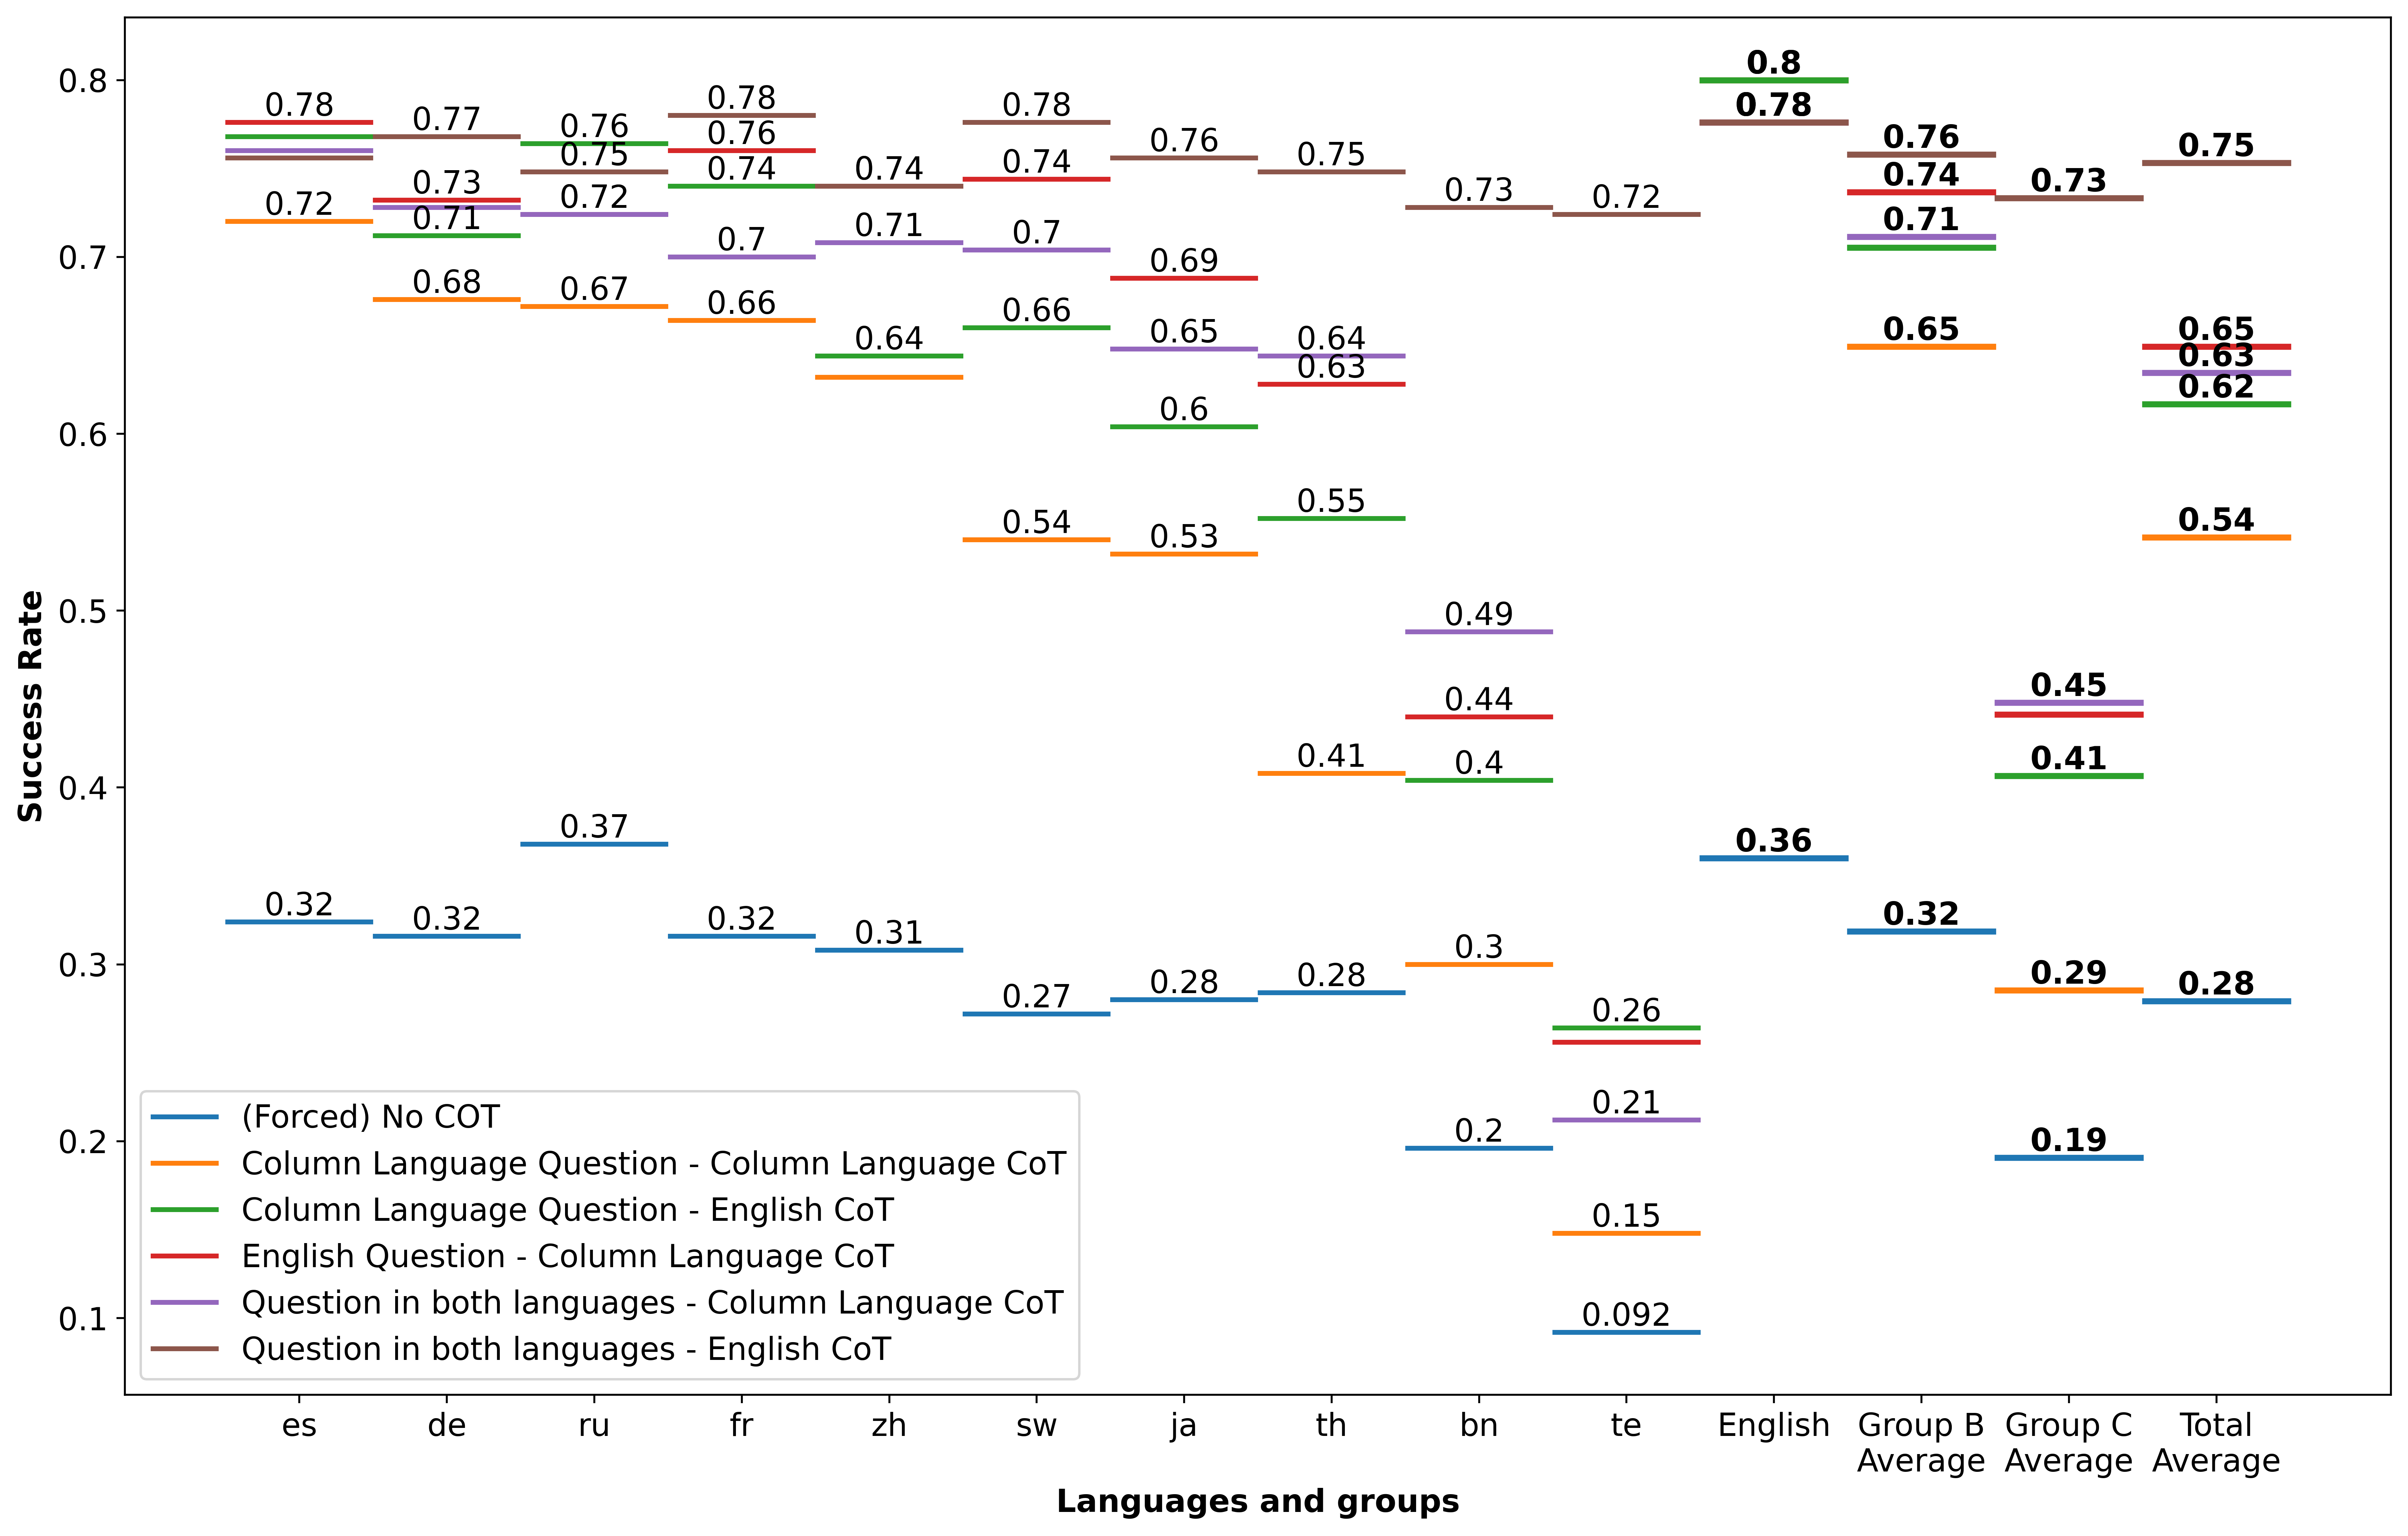

In [240]:
LANGUAGE_TO_PLOT = new_col_names
EXP_TO_PLOT = ['(Forced) No COT','Column Language Question - Column Language CoT', 'Column Language Question - English CoT', 'English Question - Column Language CoT', 'Question in both languages - Column Language CoT', 'Question in both languages - English CoT']
EXP_NAMES_TO_SHOW = EXP_TO_PLOT
X_TICKS  = ['es', 'de', 'ru', 'fr', 'zh', 'sw', 'ja', 'th', 'bn', 'te','English','Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ['English', 'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "MGSM - Full Comparison Graph"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 500
FIG_SIZE = (14,9)
FONT_SIZE = 13
Y_LIM = (None,None)
DROP_RESULT_FOR_VISUAL = [('es','Question in both languages - English CoT'),('es','Question in both languages - Column Language CoT'),('es','Column Language Question - English CoT'),
               ('de','Question in both languages - Column Language CoT'),('zh','Column Language Question - Column Language CoT'),('te','English Question - Column Language CoT'),
               ('Group B Average','Column Language Question - English CoT'),('Group C Average','English Question - Column Language CoT')]
default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL)

In [214]:
# Table Version
results.loc[EXP_TO_PLOT,LANGUAGE_TO_PLOT]

es     de     ru     fr  \
(Forced) No COT                                  0.3240 0.3160 0.3680 0.3160   
Column Language Question - Column Language CoT   0.7200 0.6760 0.6720 0.6640   
Column Language Question - English CoT           0.7680 0.7120 0.7640 0.7400   
English Question - Column Language CoT           0.7760 0.7320 0.7240 0.7600   
Question in both languages - Column Language CoT 0.7600 0.7280 0.7240 0.7000   
Question in both languages - English CoT         0.7560 0.7680 0.7480 0.7800   

                                                     zh     sw     ja     th  \
(Forced) No COT                                  0.3080 0.2720 0.2800 0.2840   
Column Language Question - Column Language CoT   0.6320 0.5400 0.5320 0.4080   
Column Language Question - English CoT           0.6440 0.6600 0.6040 0.5520   
English Question - Column Language CoT           0.7400 0.7440 0.6880 0.6280   
Question in both languages - Column Language CoT 0.7080 0.7040 0.6480 0.6440   
Question in both languages - English CoT         0.7400 0.7760 0.7560 0.7480   

                                                     bn     te  English  \
(Forced) No COT                                  0.1960 0.0920   0.3600   
Column Language Question - Column Language CoT   0.3000 0.1480   0.8000   
Column Language Question - English CoT           0.4040 0.2640   0.8000   
English Question - Column Language CoT           0.4400 0.2560   0.7760   
Question in both languages - Column Language CoT 0.4880 0.2120   0.7760   
Question in both languages - English CoT         0.7280 0.7240   0.7760   

                                                  Group B Average  \
(Forced) No COT                                            0.3187   
Column Language Question - Column Language CoT             0.6493   
Column Language Question - English CoT                     0.7053   
English Question - Column Language CoT                     0.7367   
Question in both languages - Column Language CoT           0.7113   
Question in both languages - English CoT                   0.7580   

                                                  Group C Average  \
(Forced) No COT                                            0.1907   
Column Language Question - Column Language CoT             0.2853   
Column Language Question - English CoT                     0.4067   
English Question - Column Language CoT                     0.4413   
Question in both languages - Column Language CoT           0.4480   
Question in both languages - English CoT                   0.7333   

                                                  Total Average  
(Forced) No COT                                          0.2792  
Column Language Question - Column Language CoT           0.5415  
Column Language Question - English CoT                   0.6168  
English Question - Column Language CoT                   0.6493  
Question in both languages - Column Language CoT         0.6345  
Question in both languages - English CoT                 0.7533

# Part 3 - CoT Language Effect 

### Figure 3.1 - Question in Column Language: CoT Language Comparison

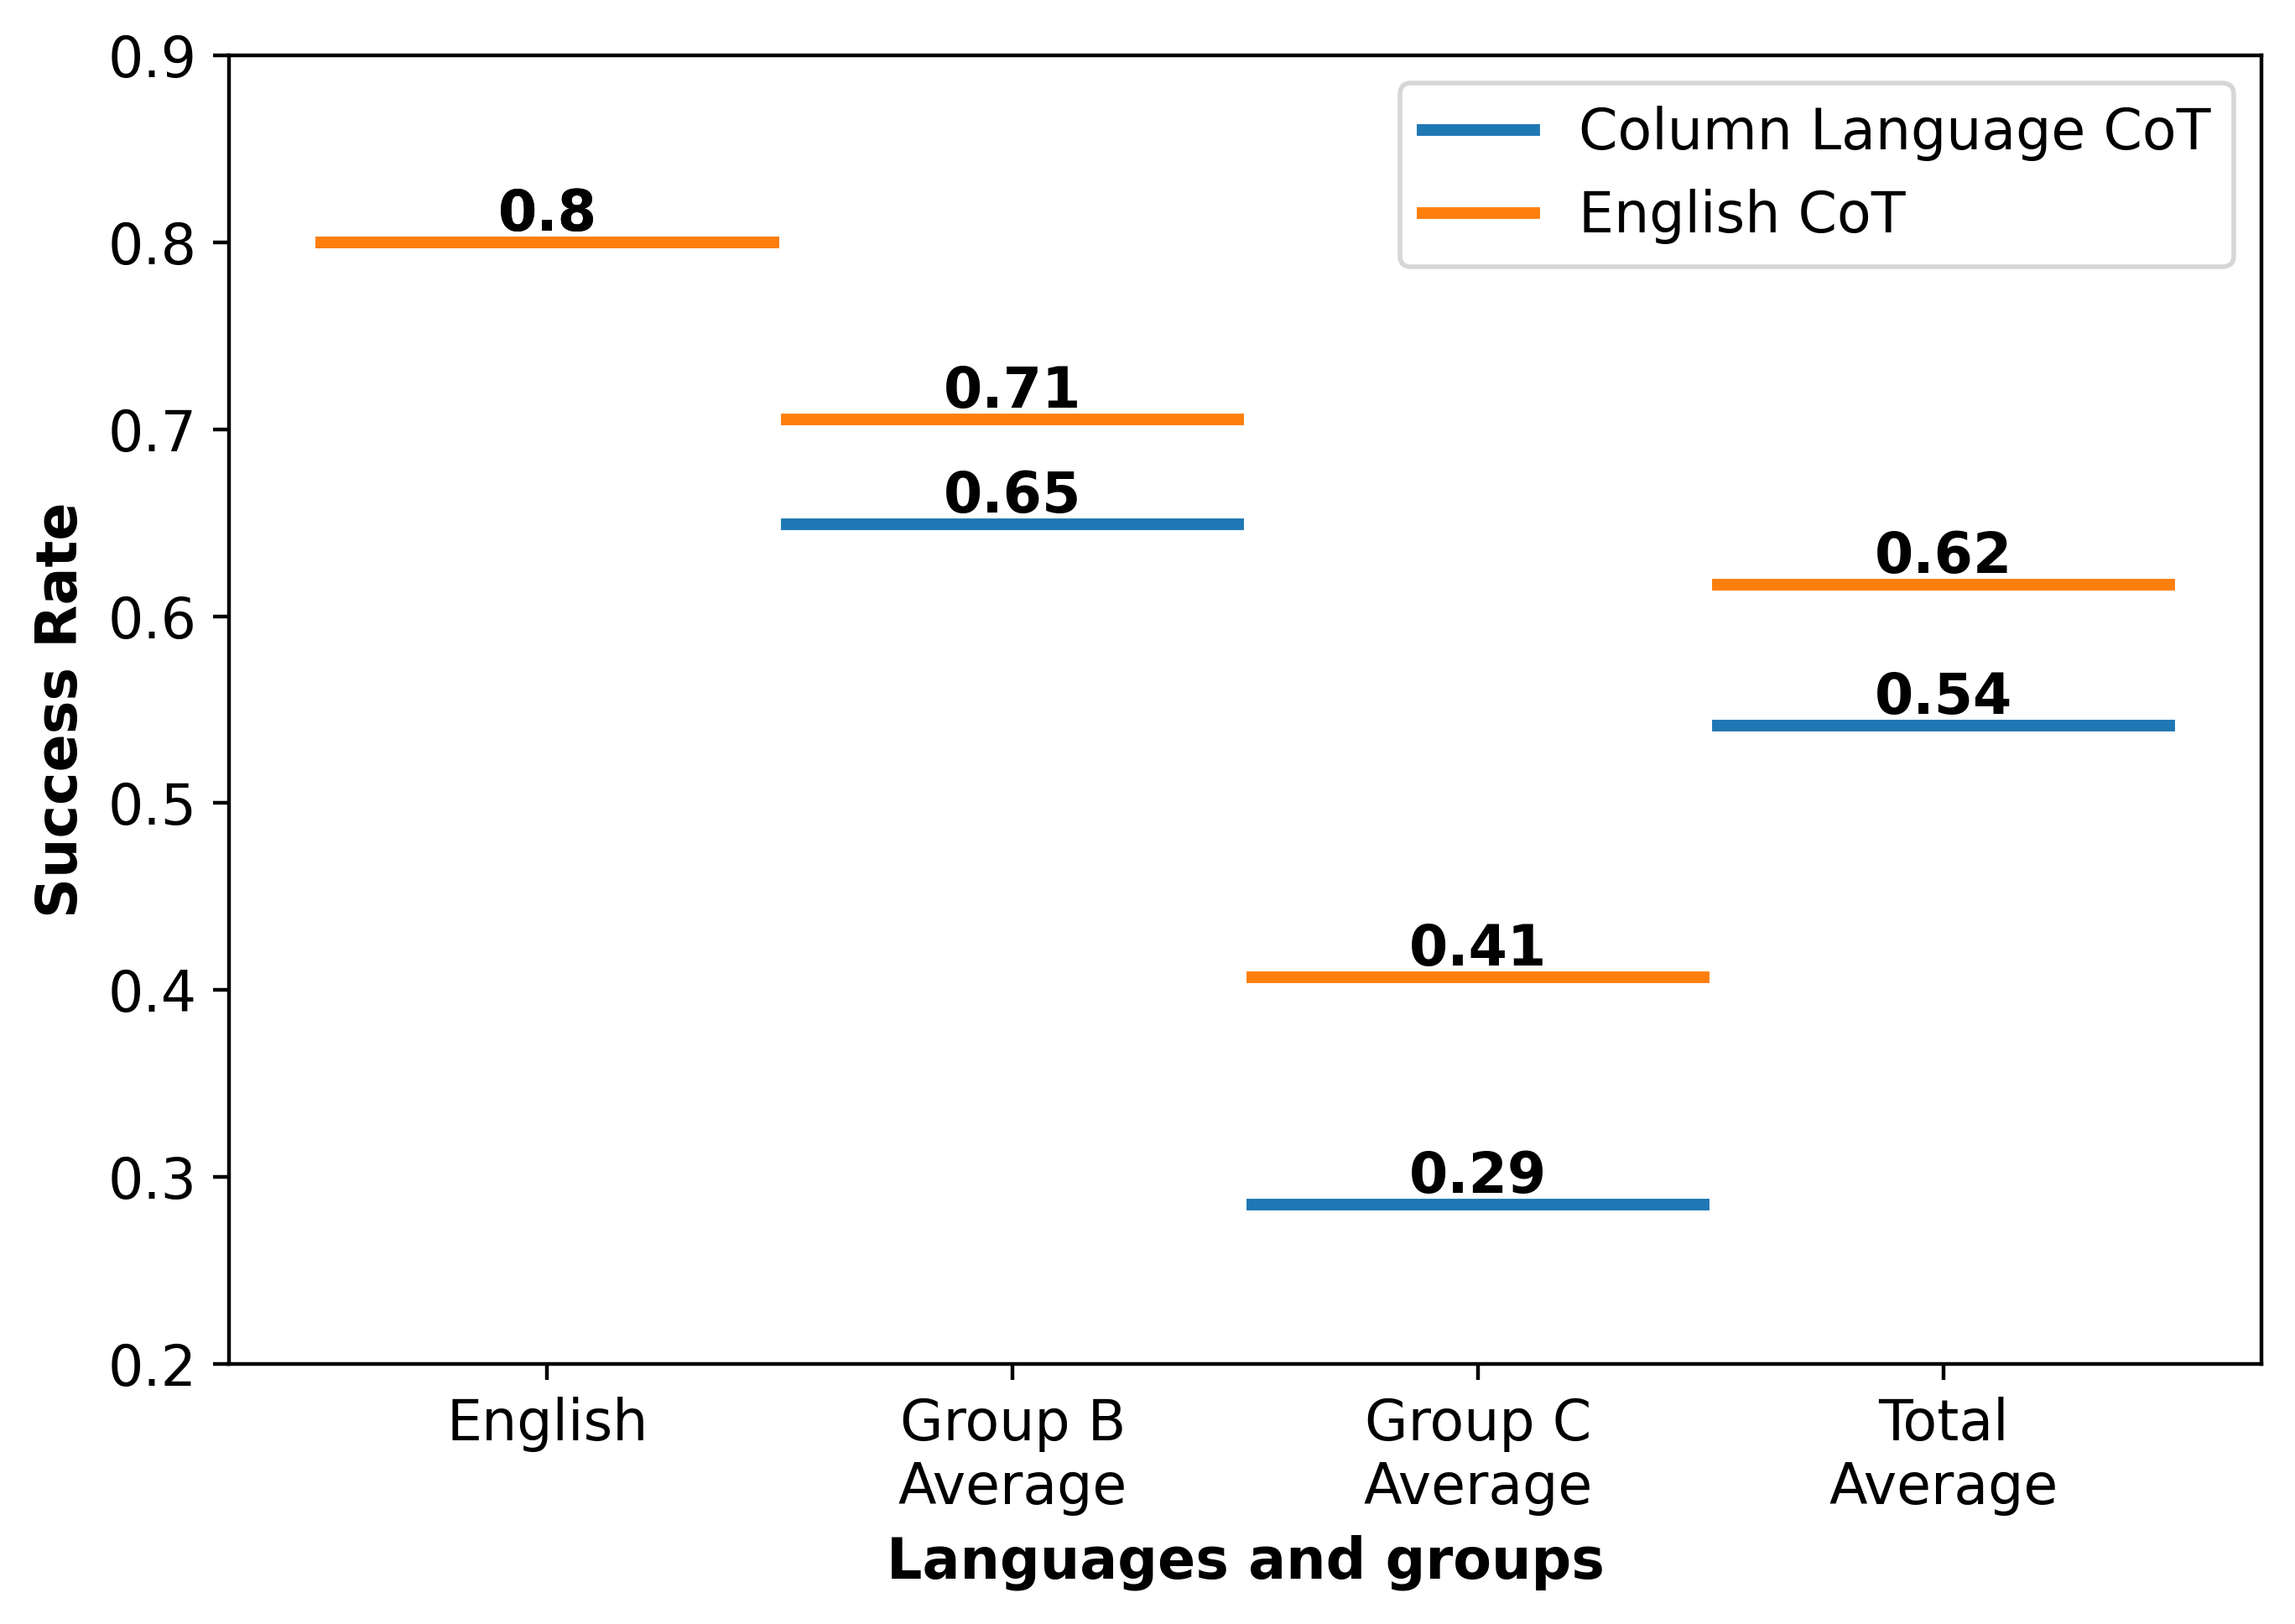

In [241]:
LANGUAGE_TO_PLOT = ['English', 'Group B Average', 'Group C Average', 'Total Average']
EXP_TO_PLOT = ['Column Language Question - Column Language CoT', 'Column Language Question - English CoT']
EXP_NAMES_TO_SHOW = ['Column Language CoT', 'English CoT']
X_TICKS  = ['English','Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ['English', 'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "Question in Column Language - CoT Language Comparison"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 400
FIG_SIZE = (7,5)
Y_LIM = (0.2,0.9)
FONT_SIZE = 12
DROP_RESULT_FOR_VISUAL = []
default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL)

### Figure 3.2 - Question in English: CoT Language Comparison
Because Enlish Question - English CoT is a special case we need to make custom code here

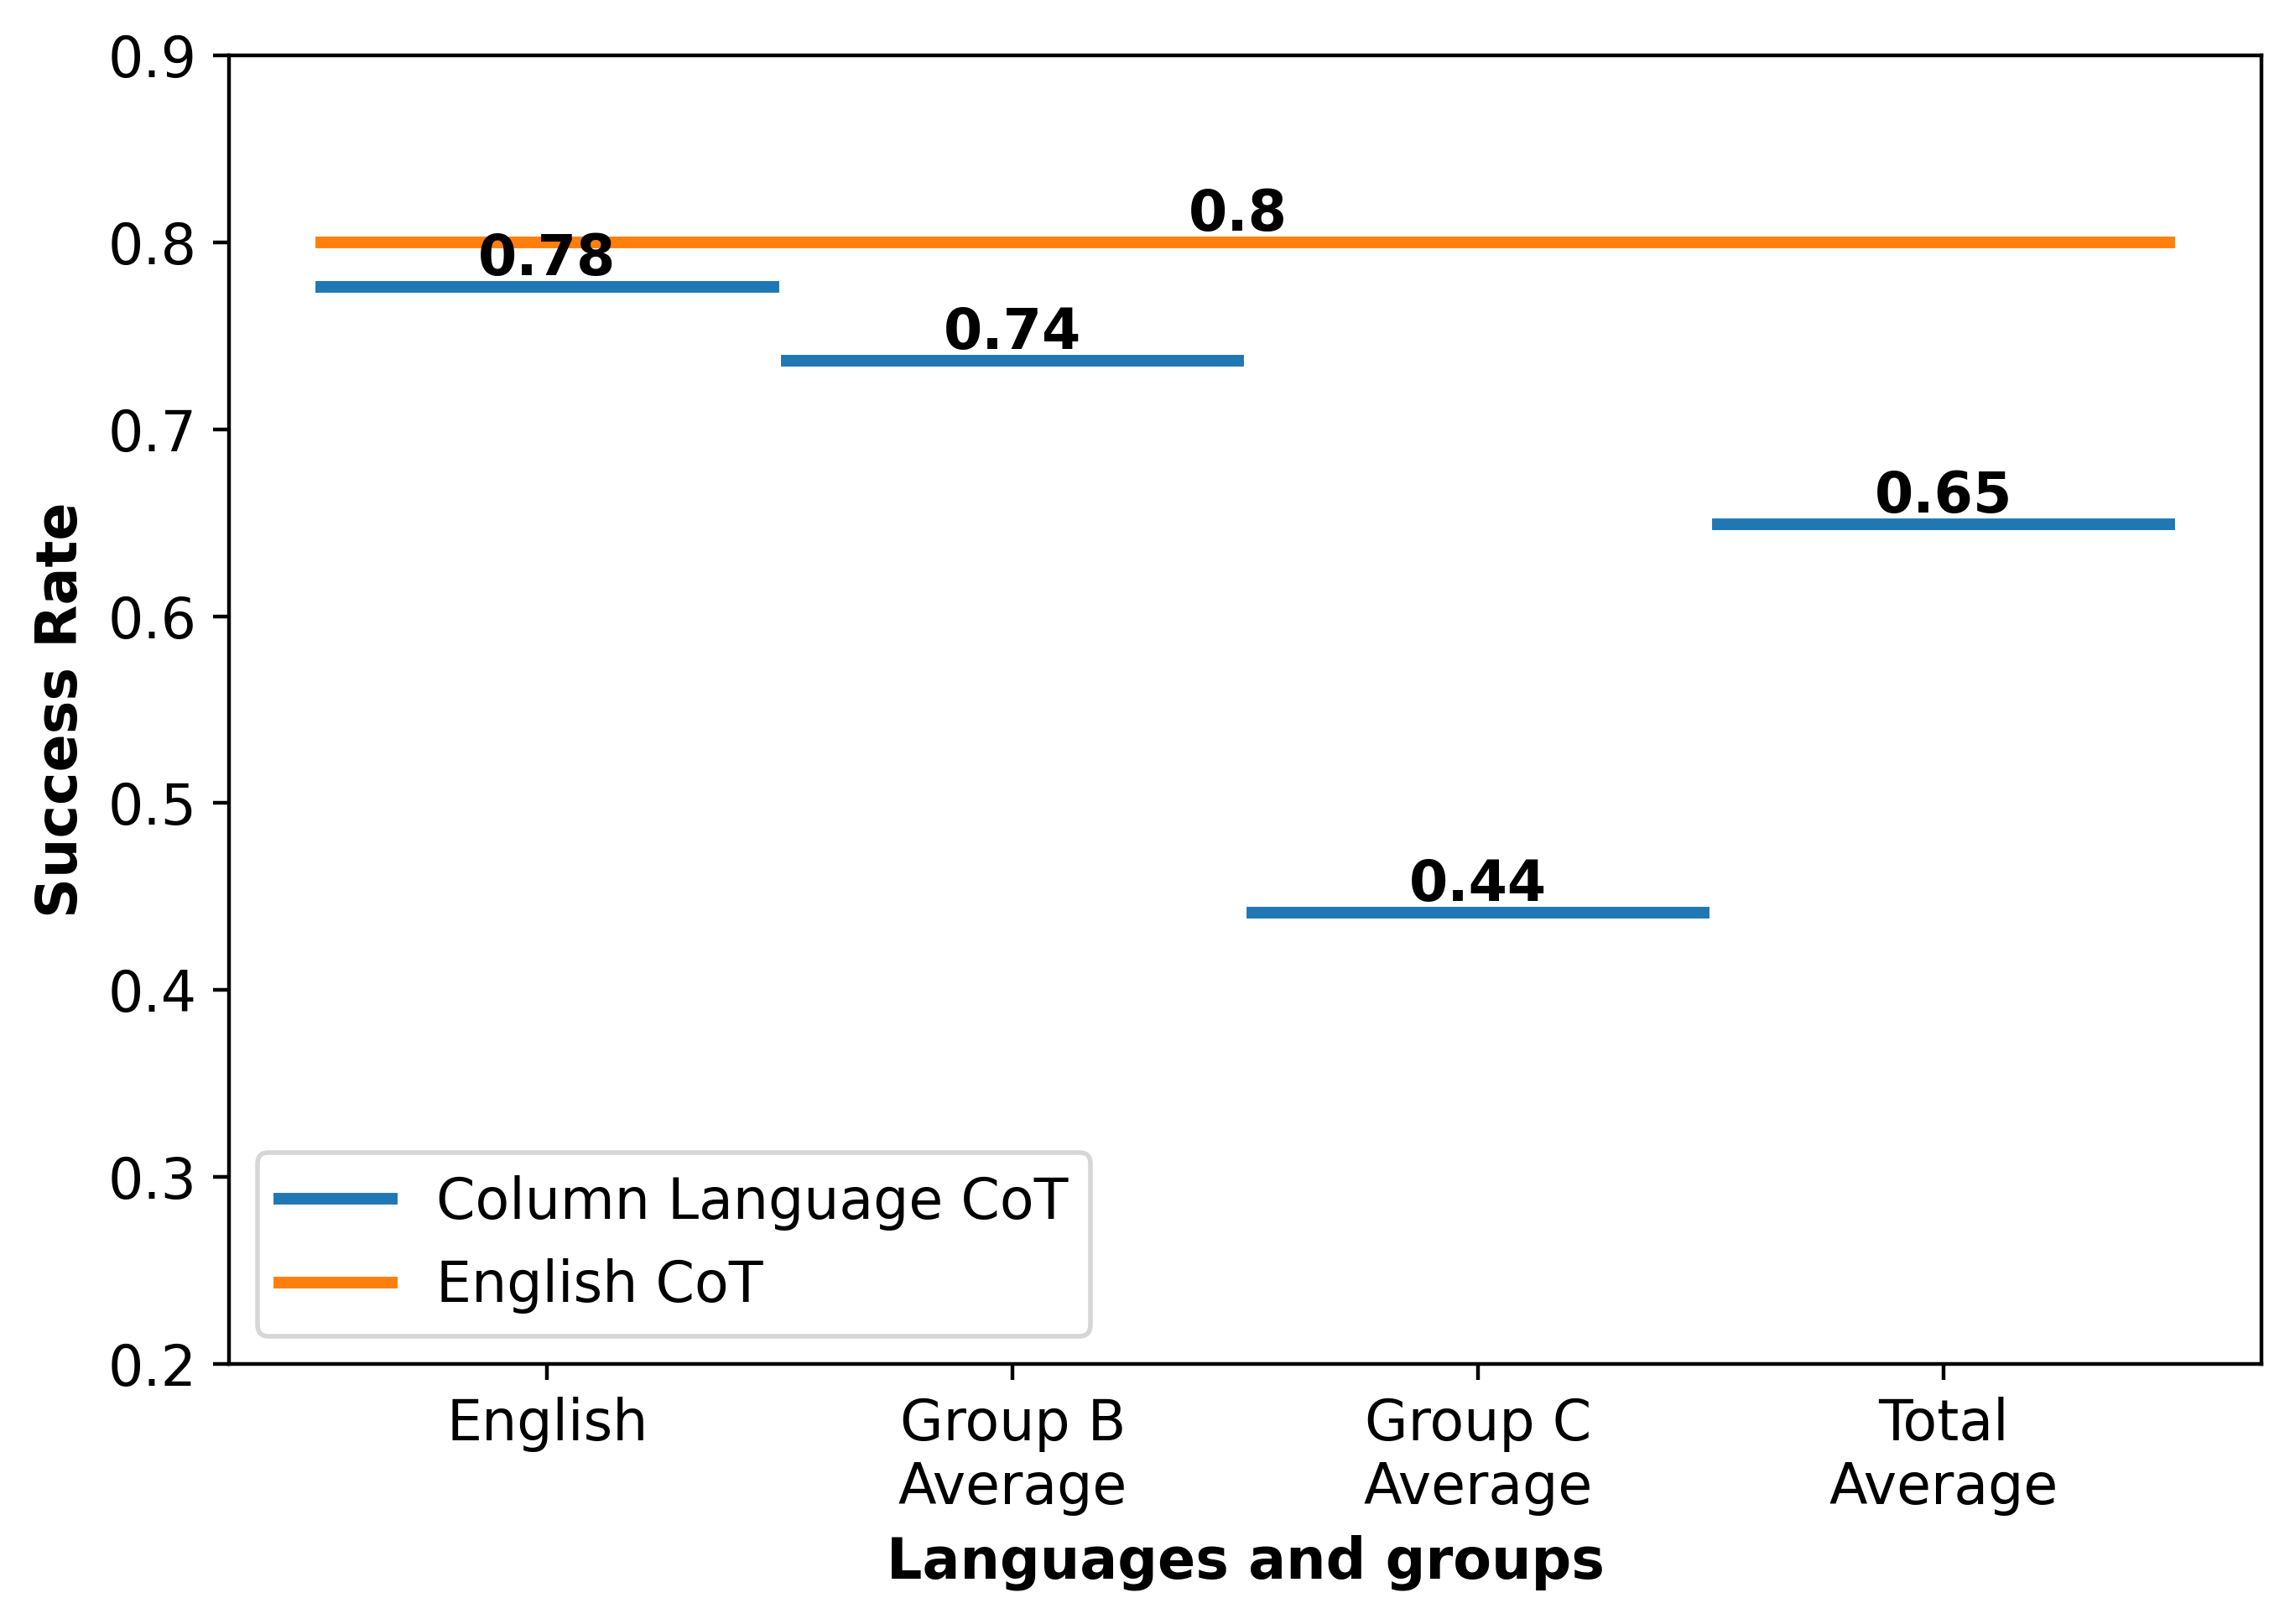

In [250]:
LANGUAGE_TO_PLOT = ['English', 'Group B Average', 'Group C Average', 'Total Average']
EXP_TO_PLOT = ['English Question - Column Language CoT']
EXP_NAMES_TO_SHOW = ['Column Language CoT', 'English CoT']
X_TICKS  = ['English','Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ['English', 'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "Question in English - CoT Language Comparison"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 400
FIG_SIZE = (7,5)
Y_LIM = (0.2,0.9)
FONT_SIZE = 12
DROP_RESULT_FOR_VISUAL = []

matplotlib.rcParams.update({'font.size': FONT_SIZE})
x = np.arange(len(LANGUAGE_TO_PLOT))  # the label locations
width = 0.97  # the width of the bars

fig, ax = plt.subplots(figsize=FIG_SIZE,dpi = RES)

for idx_exp, exp in enumerate(EXP_TO_PLOT):
    exp_data = results.loc[exp,LANGUAGE_TO_PLOT].values
    for i, lang in enumerate(LANGUAGE_TO_PLOT):
        if lang in COLS_TO_BOLD:
            ax.plot([x[i] - width/2, x[i] + width/2], [exp_data[i], exp_data[i]], color=get_color(idx_exp,2), linewidth=2.5, label= EXP_NAMES_TO_SHOW[idx_exp] if i == 0 else "")
            if not (lang,exp) in DROP_RESULT_FOR_VISUAL:
                ax.text(x[i], exp_data[i], f'{exp_data[i]:.2}', color='black', va='bottom', ha='center',fontweight='bold') 
        else:
            ax.plot([x[i] - width/2, x[i] + width/2], [exp_data[i], exp_data[i]], color=get_color(idx_exp,2), linewidth=2, label= EXP_NAMES_TO_SHOW[idx_exp] if i == 0 else "")
            if not (lang,exp) in DROP_RESULT_FOR_VISUAL:
                ax.text(x[i], exp_data[i], f'{exp_data[i]:.2}', color='black', va='bottom', ha='center')

# add_english_line
val = results.loc['Column Language Question - English CoT','English']
ax.plot([x[0] - width/2, x[-1] + width/2], [val,val], color=get_color(1,2), linewidth=2.5, label = "English CoT")
ax.text(x[1] + width/2, val, f'{val:.2}', color='black', va='bottom', ha='center',fontweight='bold') 

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(*Y_LIM)
ax.set_xlabel('Languages and groups',fontweight = 'bold')
ax.set_ylabel('Success Rate',fontweight = 'bold')
# ax.set_title(f'{FIG_NAME}')
ax.set_xticks(x)
ax.xaxis.set_tick_params(labelsize=FONT_SIZE)
ax.set_xticklabels(X_TICKS)
ax.legend()
fig.tight_layout()
if SAVE_PATH:
    plt.savefig(SAVE_PATH,dpi = RES)
plt.show()

### Figure 3.3 - Double Language Question: CoT Language Comparison

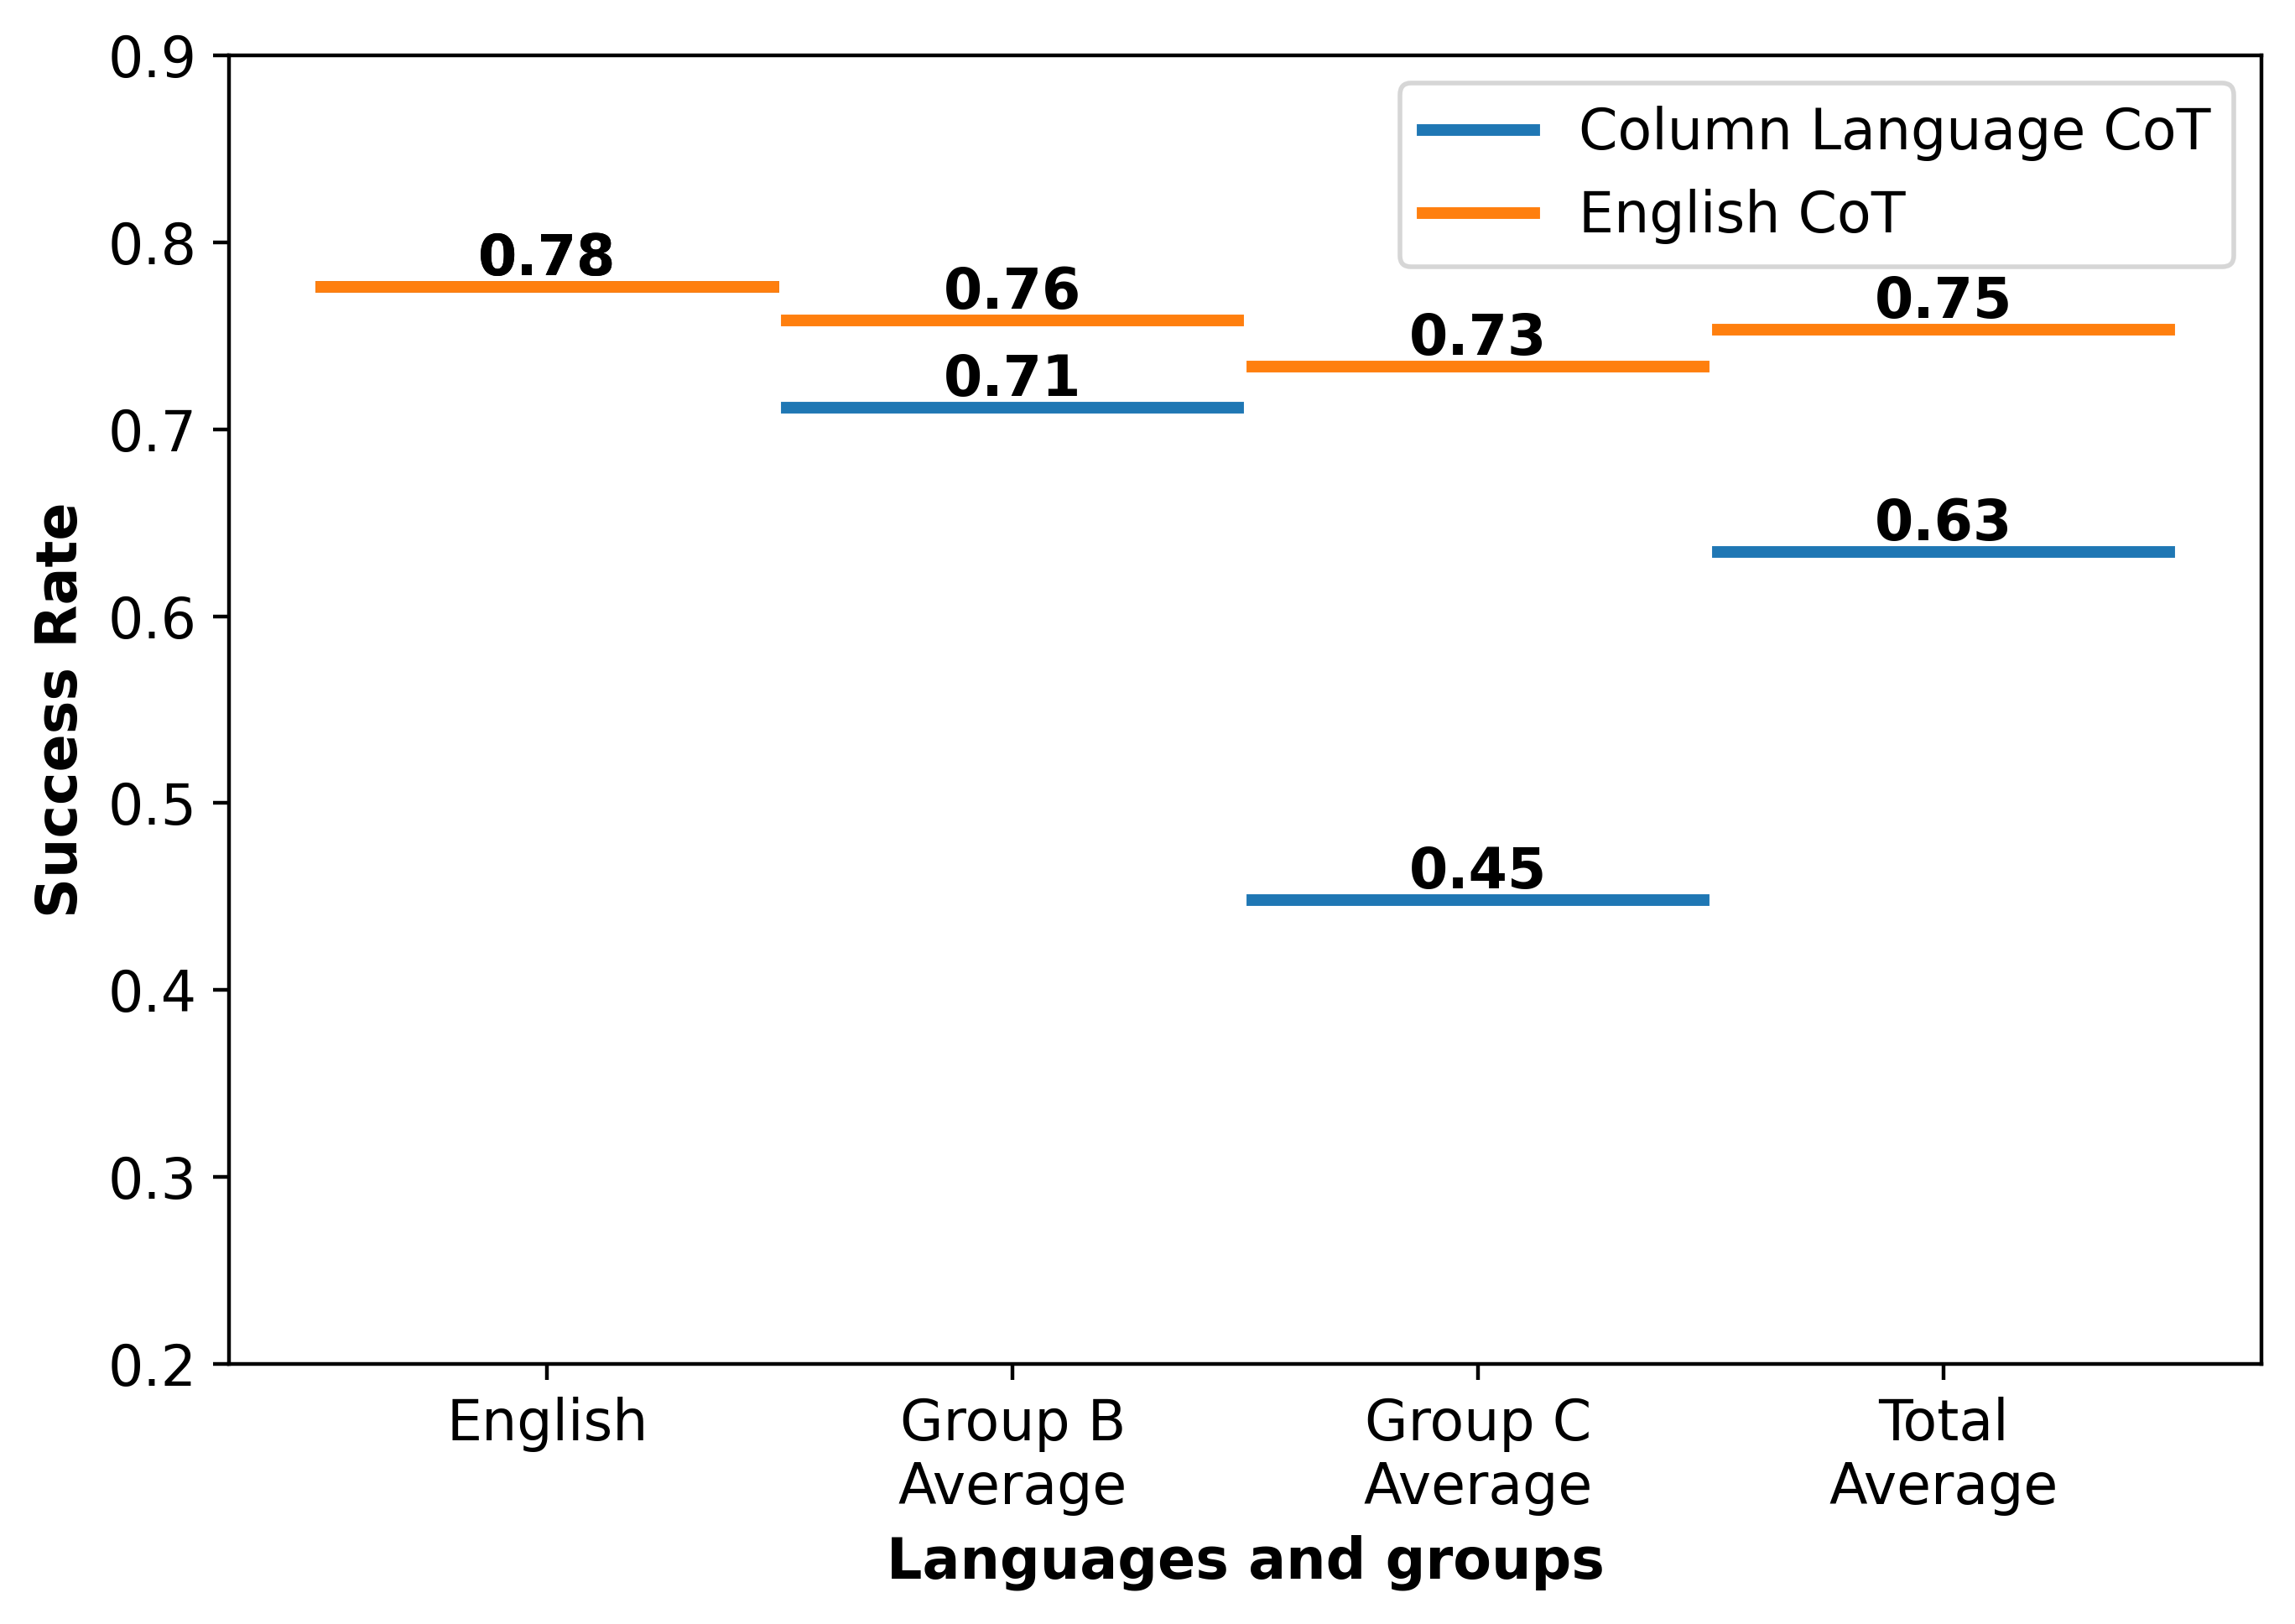

In [243]:
LANGUAGE_TO_PLOT = ['English', 'Group B Average', 'Group C Average', 'Total Average']
EXP_TO_PLOT = ['Question in both languages - Column Language CoT', 'Question in both languages - English CoT']
EXP_NAMES_TO_SHOW = ['Column Language CoT', 'English CoT']
X_TICKS  = ['English','Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ['English', 'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "Question in Both Languages - CoT Language Comparison"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 400
FIG_SIZE = (7,5)
Y_LIM = (0.2,0.9)
FONT_SIZE = 12
DROP_RESULT_FOR_VISUAL = []
default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL)

# Part 2 - Question Language Effect 

### Figure 2.1 CoT in Column Language

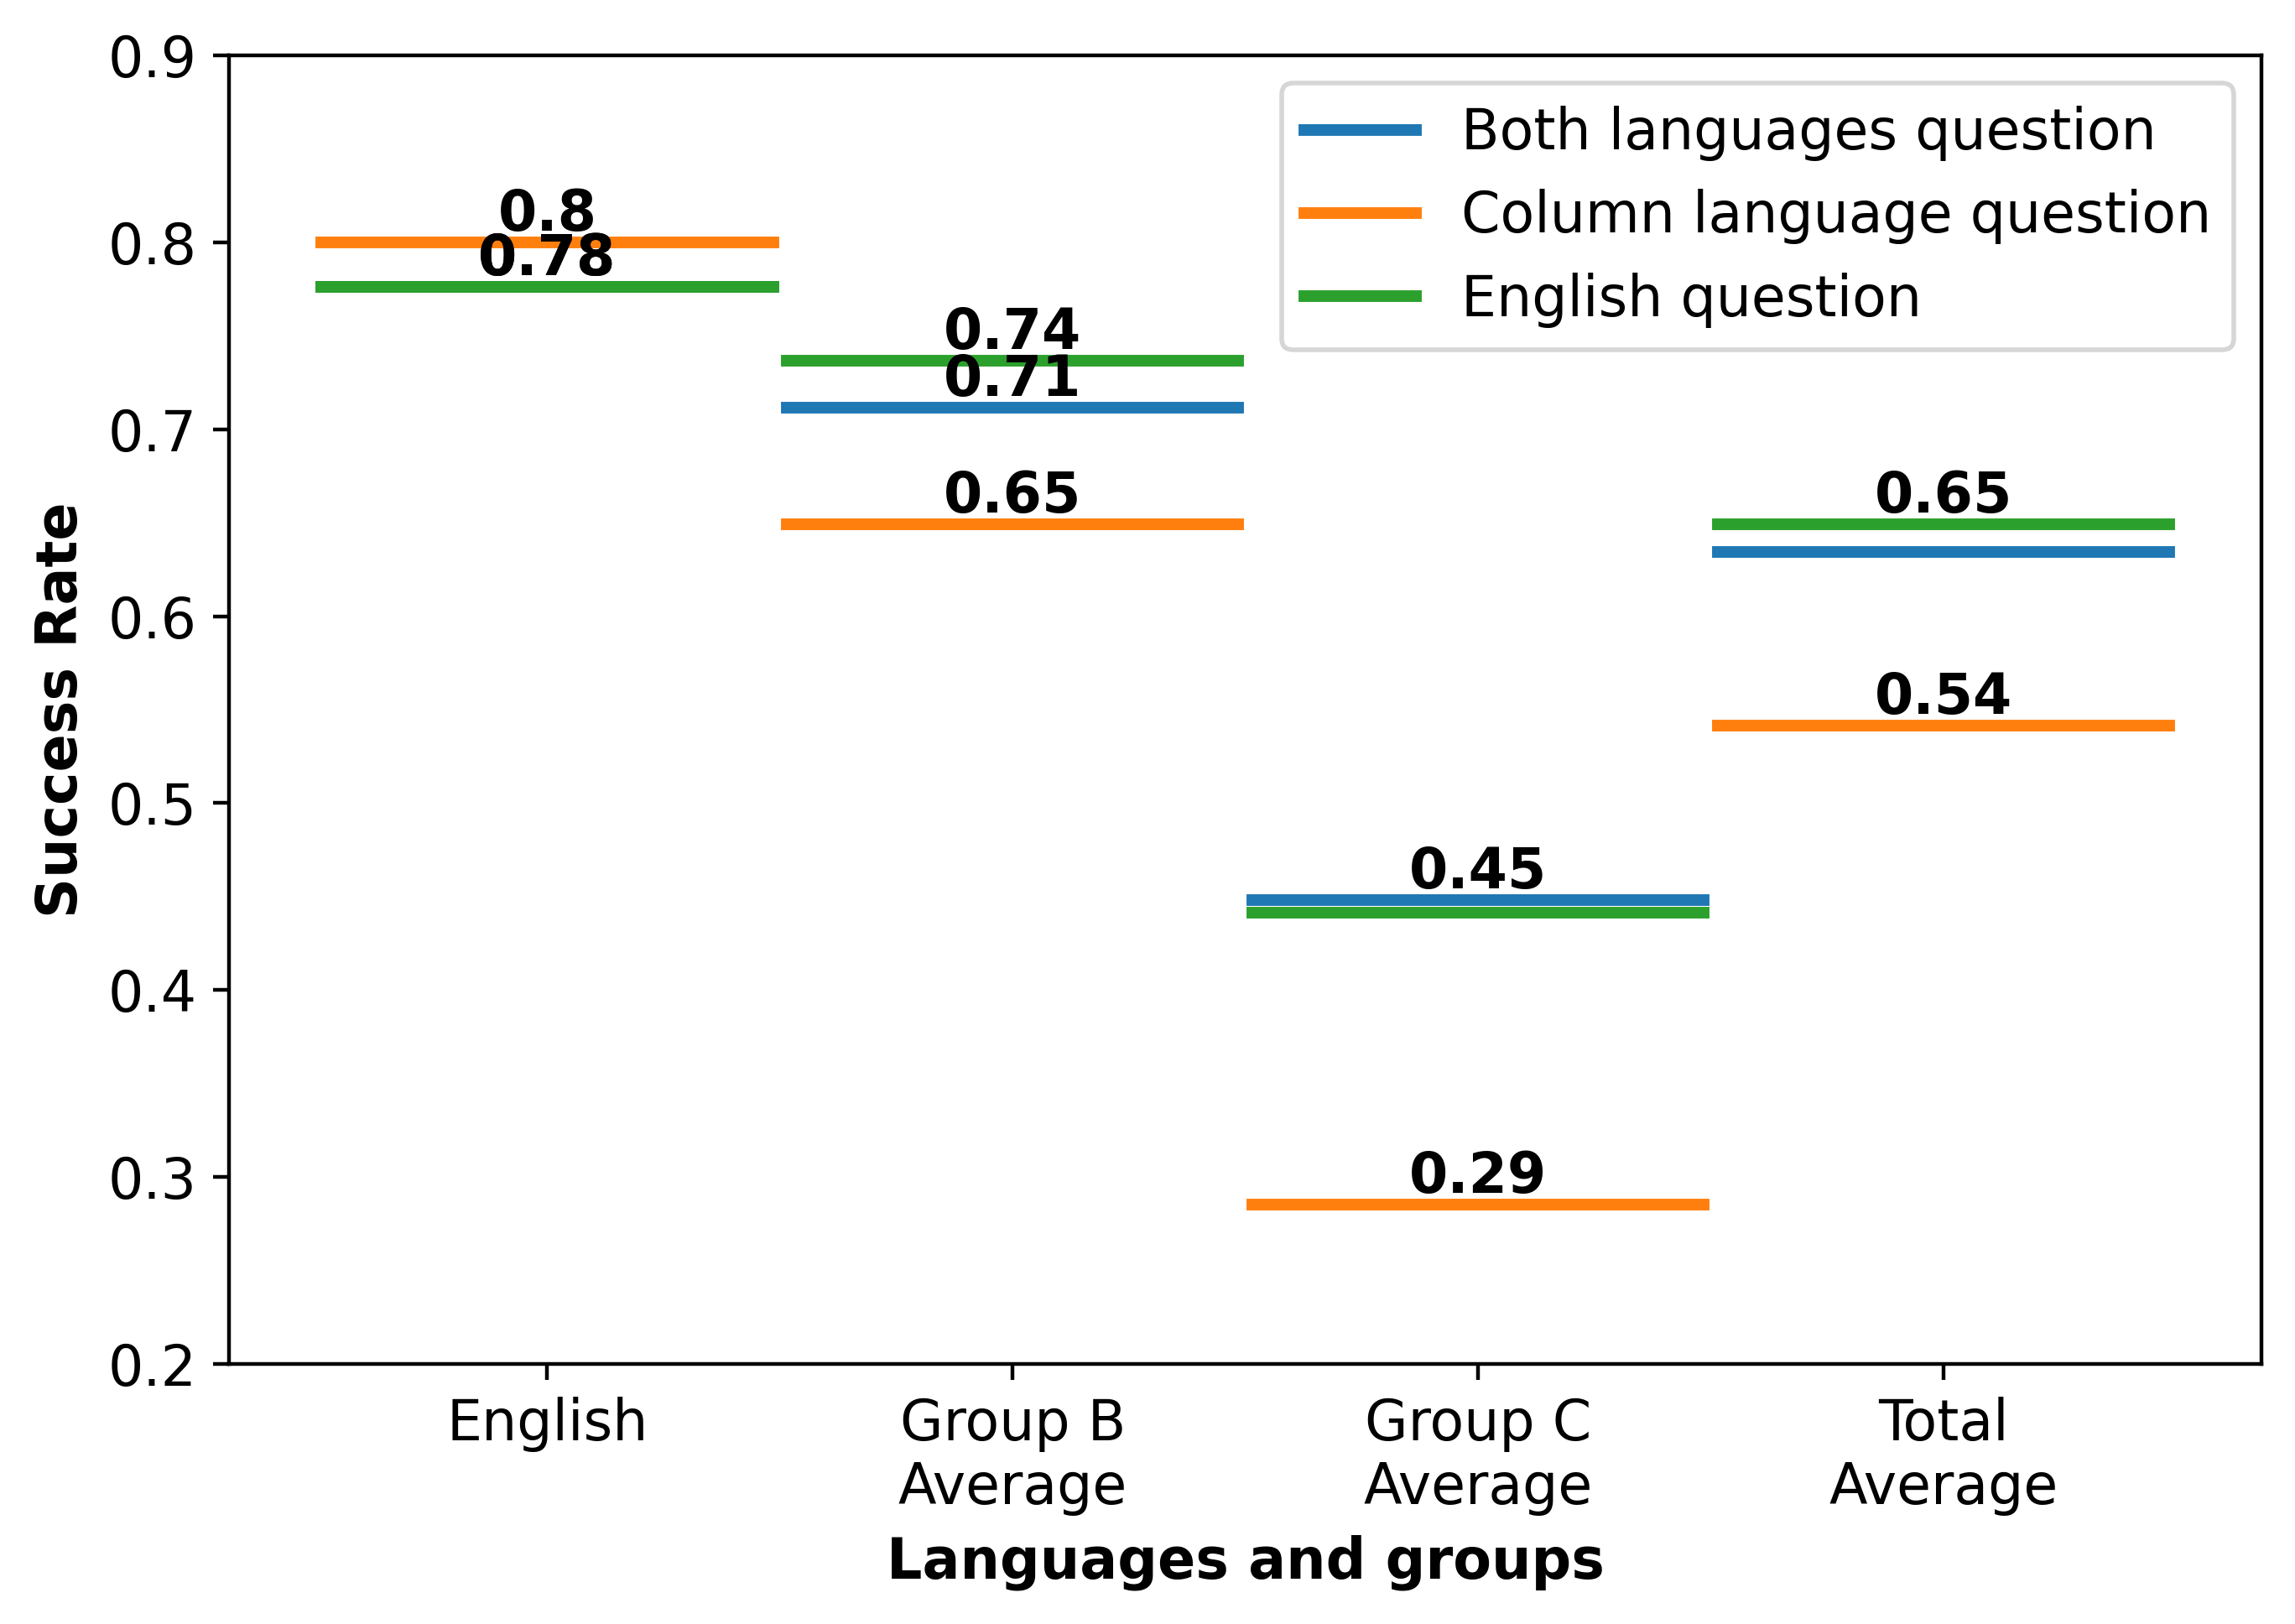

In [244]:
LANGUAGE_TO_PLOT = ['English', 'Group B Average', 'Group C Average', 'Total Average']
EXP_TO_PLOT = ['Question in both languages - Column Language CoT','Column Language Question - Column Language CoT','English Question - Column Language CoT']
EXP_NAMES_TO_SHOW = ["Both languages question",'Column language question', 'English question']
X_TICKS  = ['English','Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ['English', 'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "CoT in Column Language - Question Language Comparison"
DROP_RESULT_FOR_VISUAL = [('Group C Average','English Question - Column Language CoT'),('Total Average','Question in both languages - Column Language CoT')]
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 400
FIG_SIZE = (7,5)
Y_LIM = (0.2,0.9)
FONT_SIZE = 12
default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL)

### Figure 2.2 CoT in English - Language Comparison

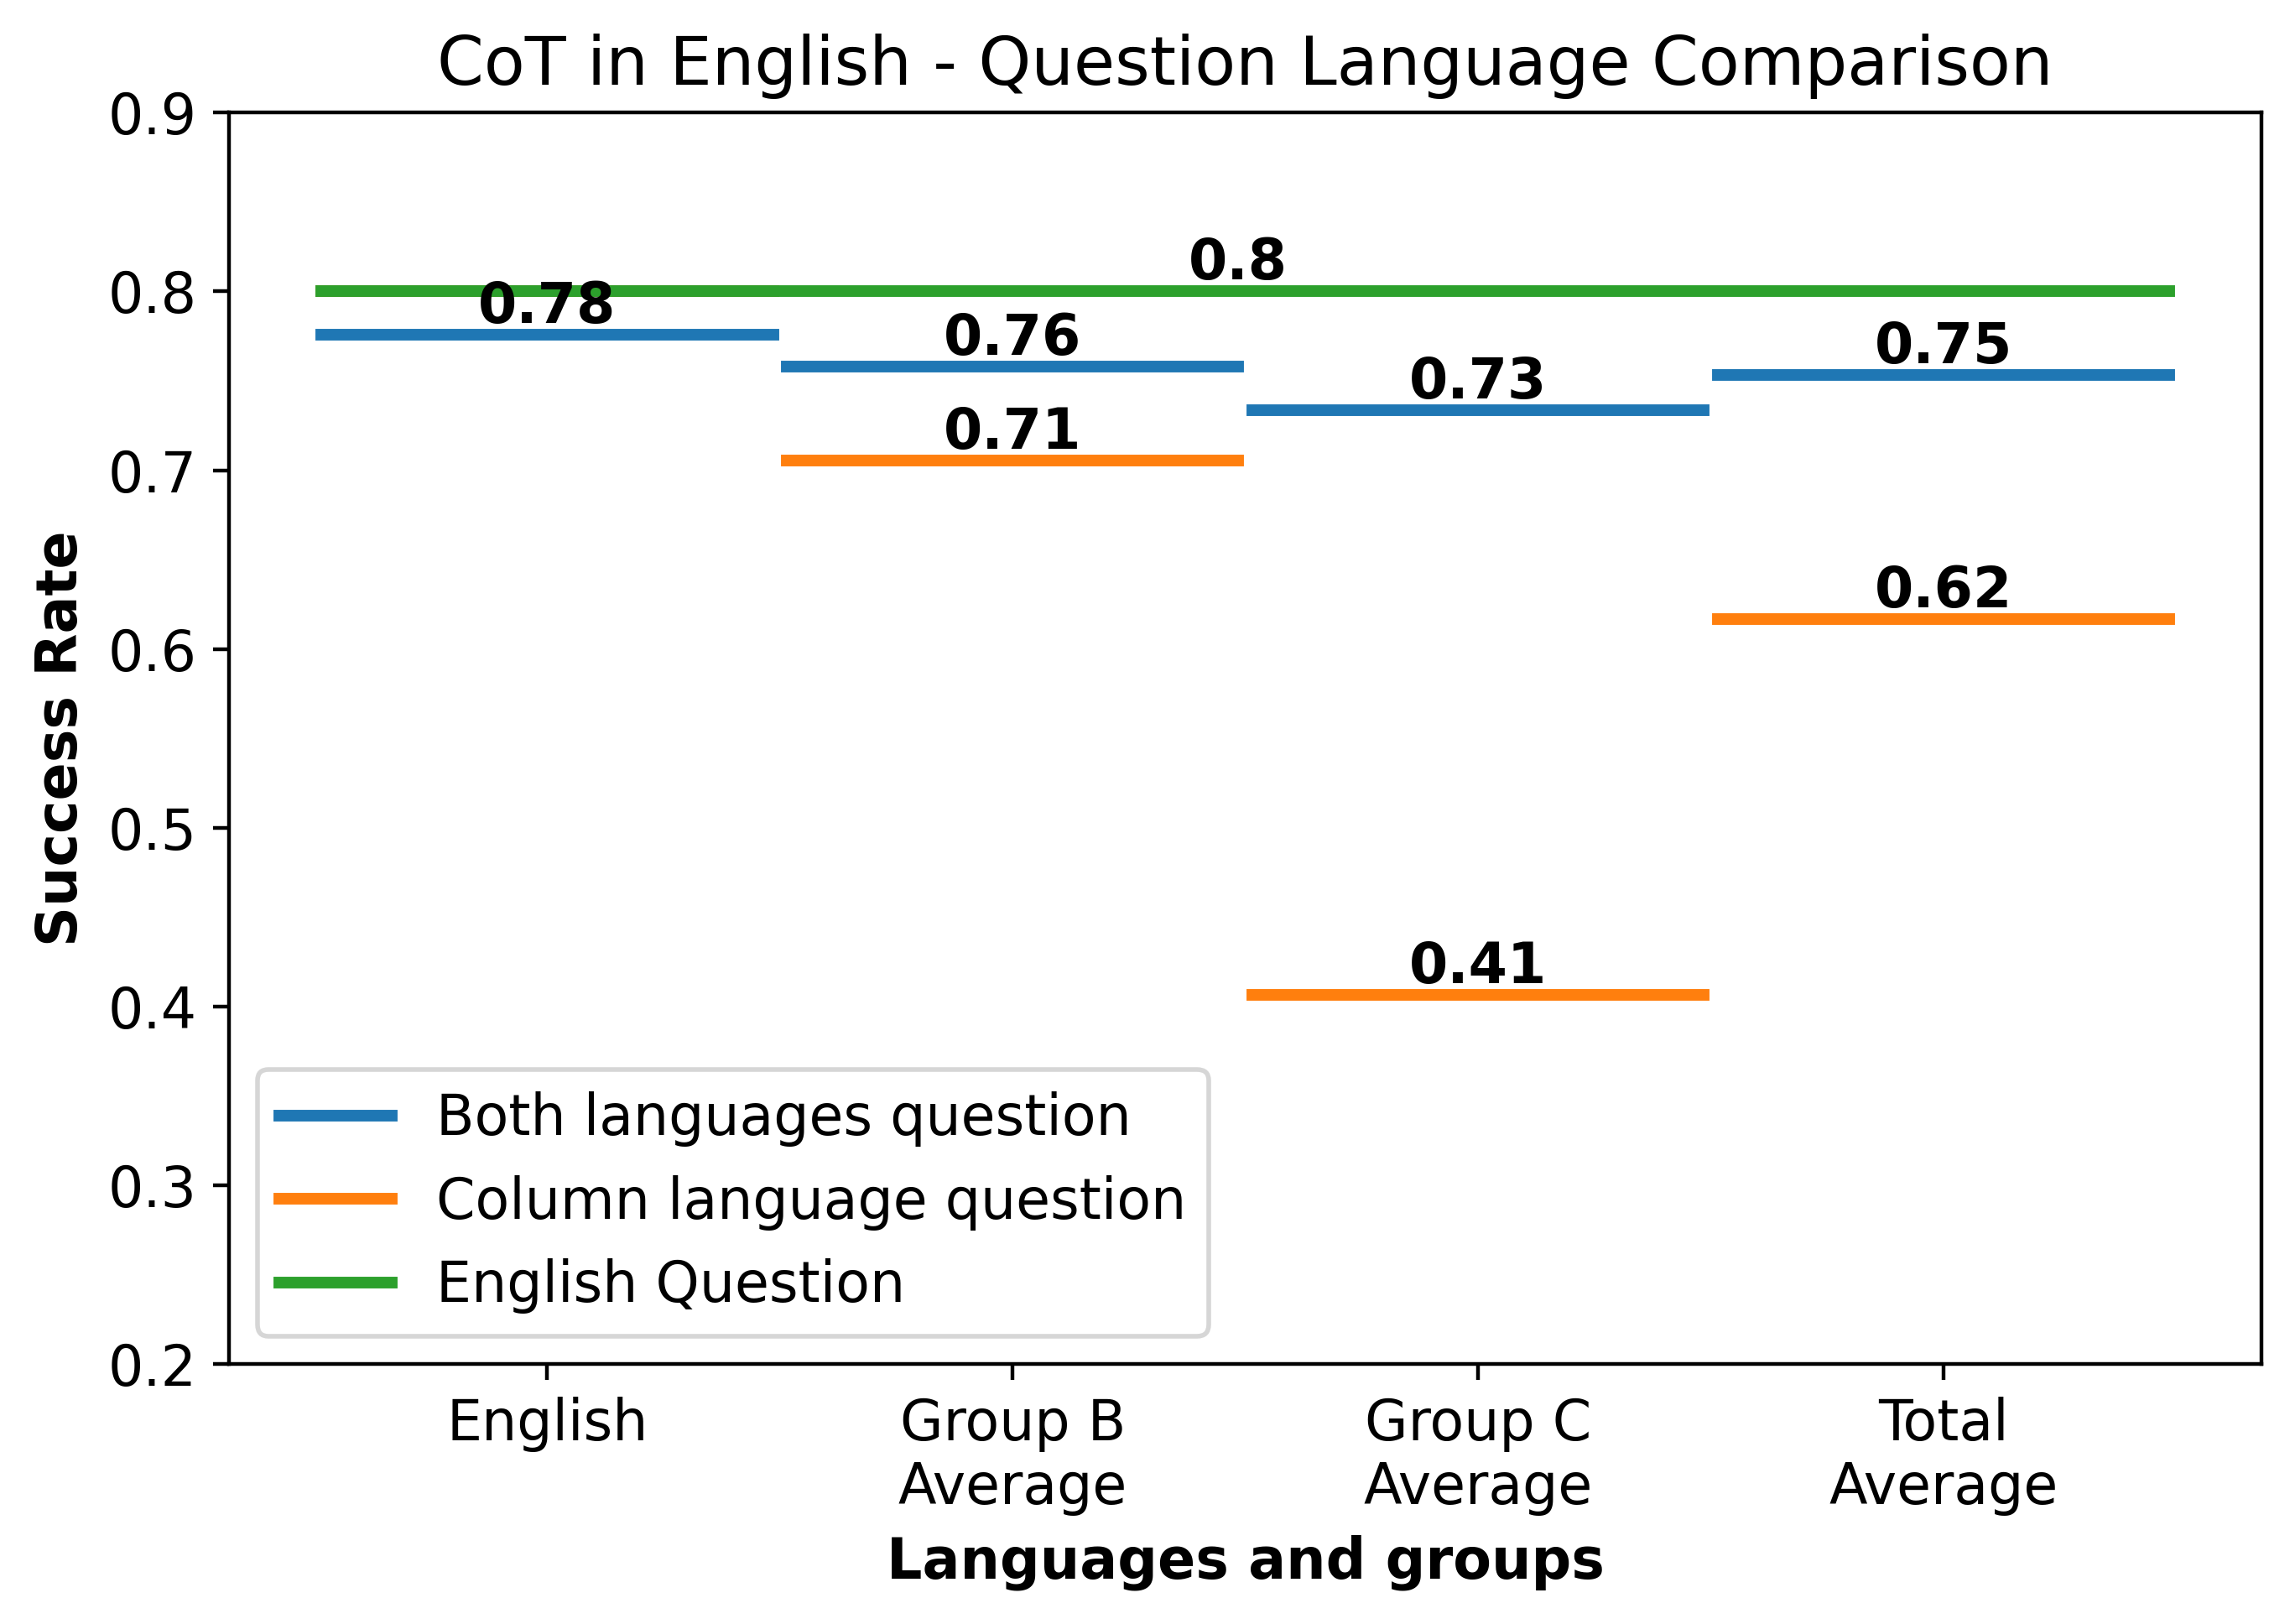

In [245]:
LANGUAGE_TO_PLOT = ['English', 'Group B Average', 'Group C Average', 'Total Average']
EXP_TO_PLOT = ['Question in both languages - English CoT','Column Language Question - English CoT']
EXP_NAMES_TO_SHOW = ["Both languages question",'Column language question', 'English question']
X_TICKS  = ['English','Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ['English', 'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "CoT in English - Question Language Comparison"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 400
FIG_SIZE = (7,5)
Y_LIM = (0.2,0.9)
FONT_SIZE = 12
DROP_RESULT_FOR_VISUAL = [("English",'Column Language Question - English CoT')]

matplotlib.rcParams.update({'font.size': FONT_SIZE})
x = np.arange(len(LANGUAGE_TO_PLOT))  # the label locations
width = 0.97  # the width of the bars

fig, ax = plt.subplots(figsize=FIG_SIZE,dpi = RES)

for idx_exp, exp in enumerate(EXP_TO_PLOT):
    exp_data = results.loc[exp,LANGUAGE_TO_PLOT].values
    for i, lang in enumerate(LANGUAGE_TO_PLOT):
        if lang in COLS_TO_BOLD:
            ax.plot([x[i] - width/2, x[i] + width/2], [exp_data[i], exp_data[i]], color=get_color(idx_exp,len(EXP_TO_PLOT) + 1), linewidth=2.5, label= EXP_NAMES_TO_SHOW[idx_exp] if i == 0 else "")
            if not (lang,exp) in DROP_RESULT_FOR_VISUAL:
                ax.text(x[i], exp_data[i], f'{exp_data[i]:.2}', color='black', va='bottom', ha='center',fontweight='bold') 
        else:
            ax.plot([x[i] - width/2, x[i] + width/2], [exp_data[i], exp_data[i]], color=get_color(idx_exp,len(EXP_TO_PLOT) + 1), linewidth=2, label= EXP_NAMES_TO_SHOW[idx_exp] if i == 0 else "")
            if not (lang,exp) in DROP_RESULT_FOR_VISUAL:
                ax.text(x[i], exp_data[i], f'{exp_data[i]:.2}', color='black', va='bottom', ha='center')

# add_english_line
val = results.loc['Column Language Question - English CoT','English']
ax.plot([x[0] - width/2, x[-1] + width/2], [val,val], color=get_color(len(EXP_TO_PLOT),len(EXP_TO_PLOT) + 1), linewidth=2.5, label = "English Question")
ax.text(x[1] + width/2, val, f'{val:.2}', color='black', va='bottom', ha='center',fontweight='bold') 

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(*Y_LIM)
ax.set_xlabel('Languages and groups',fontweight = 'bold')
ax.set_ylabel('Success Rate',fontweight = 'bold')
ax.set_title(f'{FIG_NAME}')
ax.set_xticks(x)
ax.xaxis.set_tick_params(labelsize=FONT_SIZE)
ax.set_xticklabels(X_TICKS)
ax.legend()
fig.tight_layout()
if SAVE_PATH:
    plt.savefig(SAVE_PATH,dpi = RES)
plt.show()

### Experiment 4 - The benefit from step-by-step CoT as function of Lanugage representation

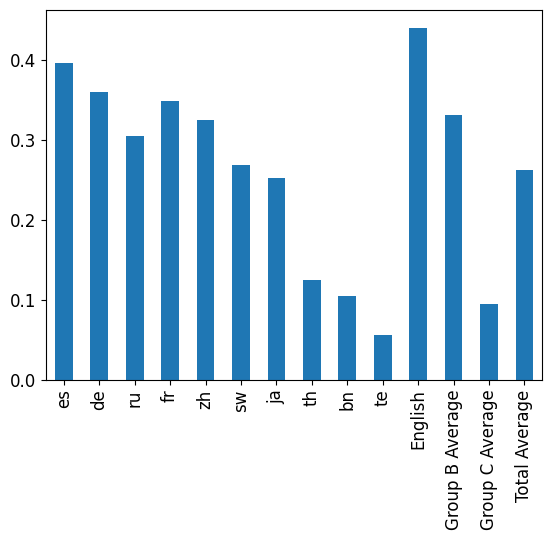

In [179]:
# Experiment Number 2 - part 2 (difference()) - Wont be included
LANGUAGE_TO_PLOT = new_col_names
diff_df = (results.loc['Column Language Question - Column Language CoT',LANGUAGE_TO_PLOT] - results.loc['(Forced) No COT',LANGUAGE_TO_PLOT])
diff_df.plot(kind = 'bar')
plt.show()

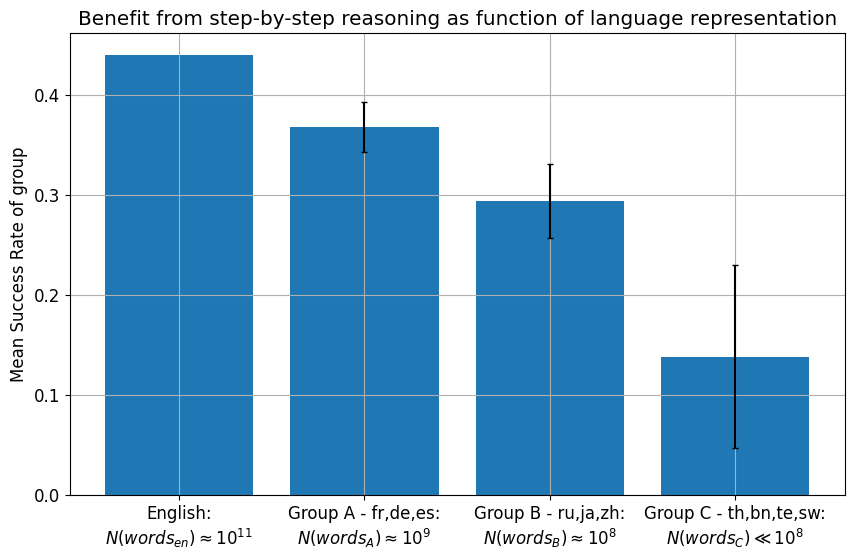

In [181]:
# Experiment 3 - Comparison Based on published gpt3 data distribution
lang_dist['n_words_log10'] = lang_dist['number of words'].apply(np.log10)
groups = [['English'],['fr','de','es'],['ru','ja','zh'],['th','bn','te','sw']]
groups_names = ['English:\n' r'$N(words_{en}) \approx 10^{11}$','Group A - fr,de,es:\n' r'$N(words_A) \approx 10^{9}$','Group B - ru,ja,zh:\n' r'$N(words_B) \approx 10^{8}$','Group C - th,bn,te,sw:\n' r'$N(words_C) \ll 10^{8}$']
groups_mean = []
groups_std = []
for g in groups:
    groups_mean.append(diff_df.loc[g].mean())
    groups_std.append(diff_df.loc[g].std())
    
plt.figure(figsize=(10, 6))
plt.bar(groups_names, groups_mean, yerr=groups_std, capsize=2)
# plt.xlabel('Language Groups by number of words in training set')
plt.ylabel('Mean Success Rate of group')
# plt.title('Benefit from step-by-step reasoning as function of language representation')
plt.grid(True)
plt.show()


##### Experiment 4 - Same for grouping by common crawl data
lang_dist['n_words_log10'] = lang_dist['number of words'].apply(np.log10)
groups = [['English'],['fr','de','es','ru','ja','zh'],['th','bn','te']]
groups_names = ['English','Group B','Group C']
groups_mean = []
groups_std = []
for g in groups:
    groups_mean.append(diff_df.loc[g].mean())
    groups_std.append(diff_df.loc[g].std())

FIG_NAME = 'Benefit from step-by-step reasoning as function of language representation'
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 400
FIG_SIZE = (10,6)
FONT_SIZE = 12

matplotlib.rcParams.update({'font.size': FONT_SIZE})
plt.figure(figsize=FIG_SIZE,dpi=RES)
plt.bar(groups_names, groups_mean, yerr=groups_std, capsize=2)
# plt.xlabel('Language Groups by number of words in training set')
plt.ylabel('Average accuracy in Group',fontweight = 'bold')
# plt.title(FIG_NAME)
plt.grid(True)
if SAVE_PATH:
    plt.savefig(SAVE_PATH,dpi = RES)
plt.show()


# Part 4 - L-COT

## Fig 4.1 - Results Improvements (GPT 3.5)

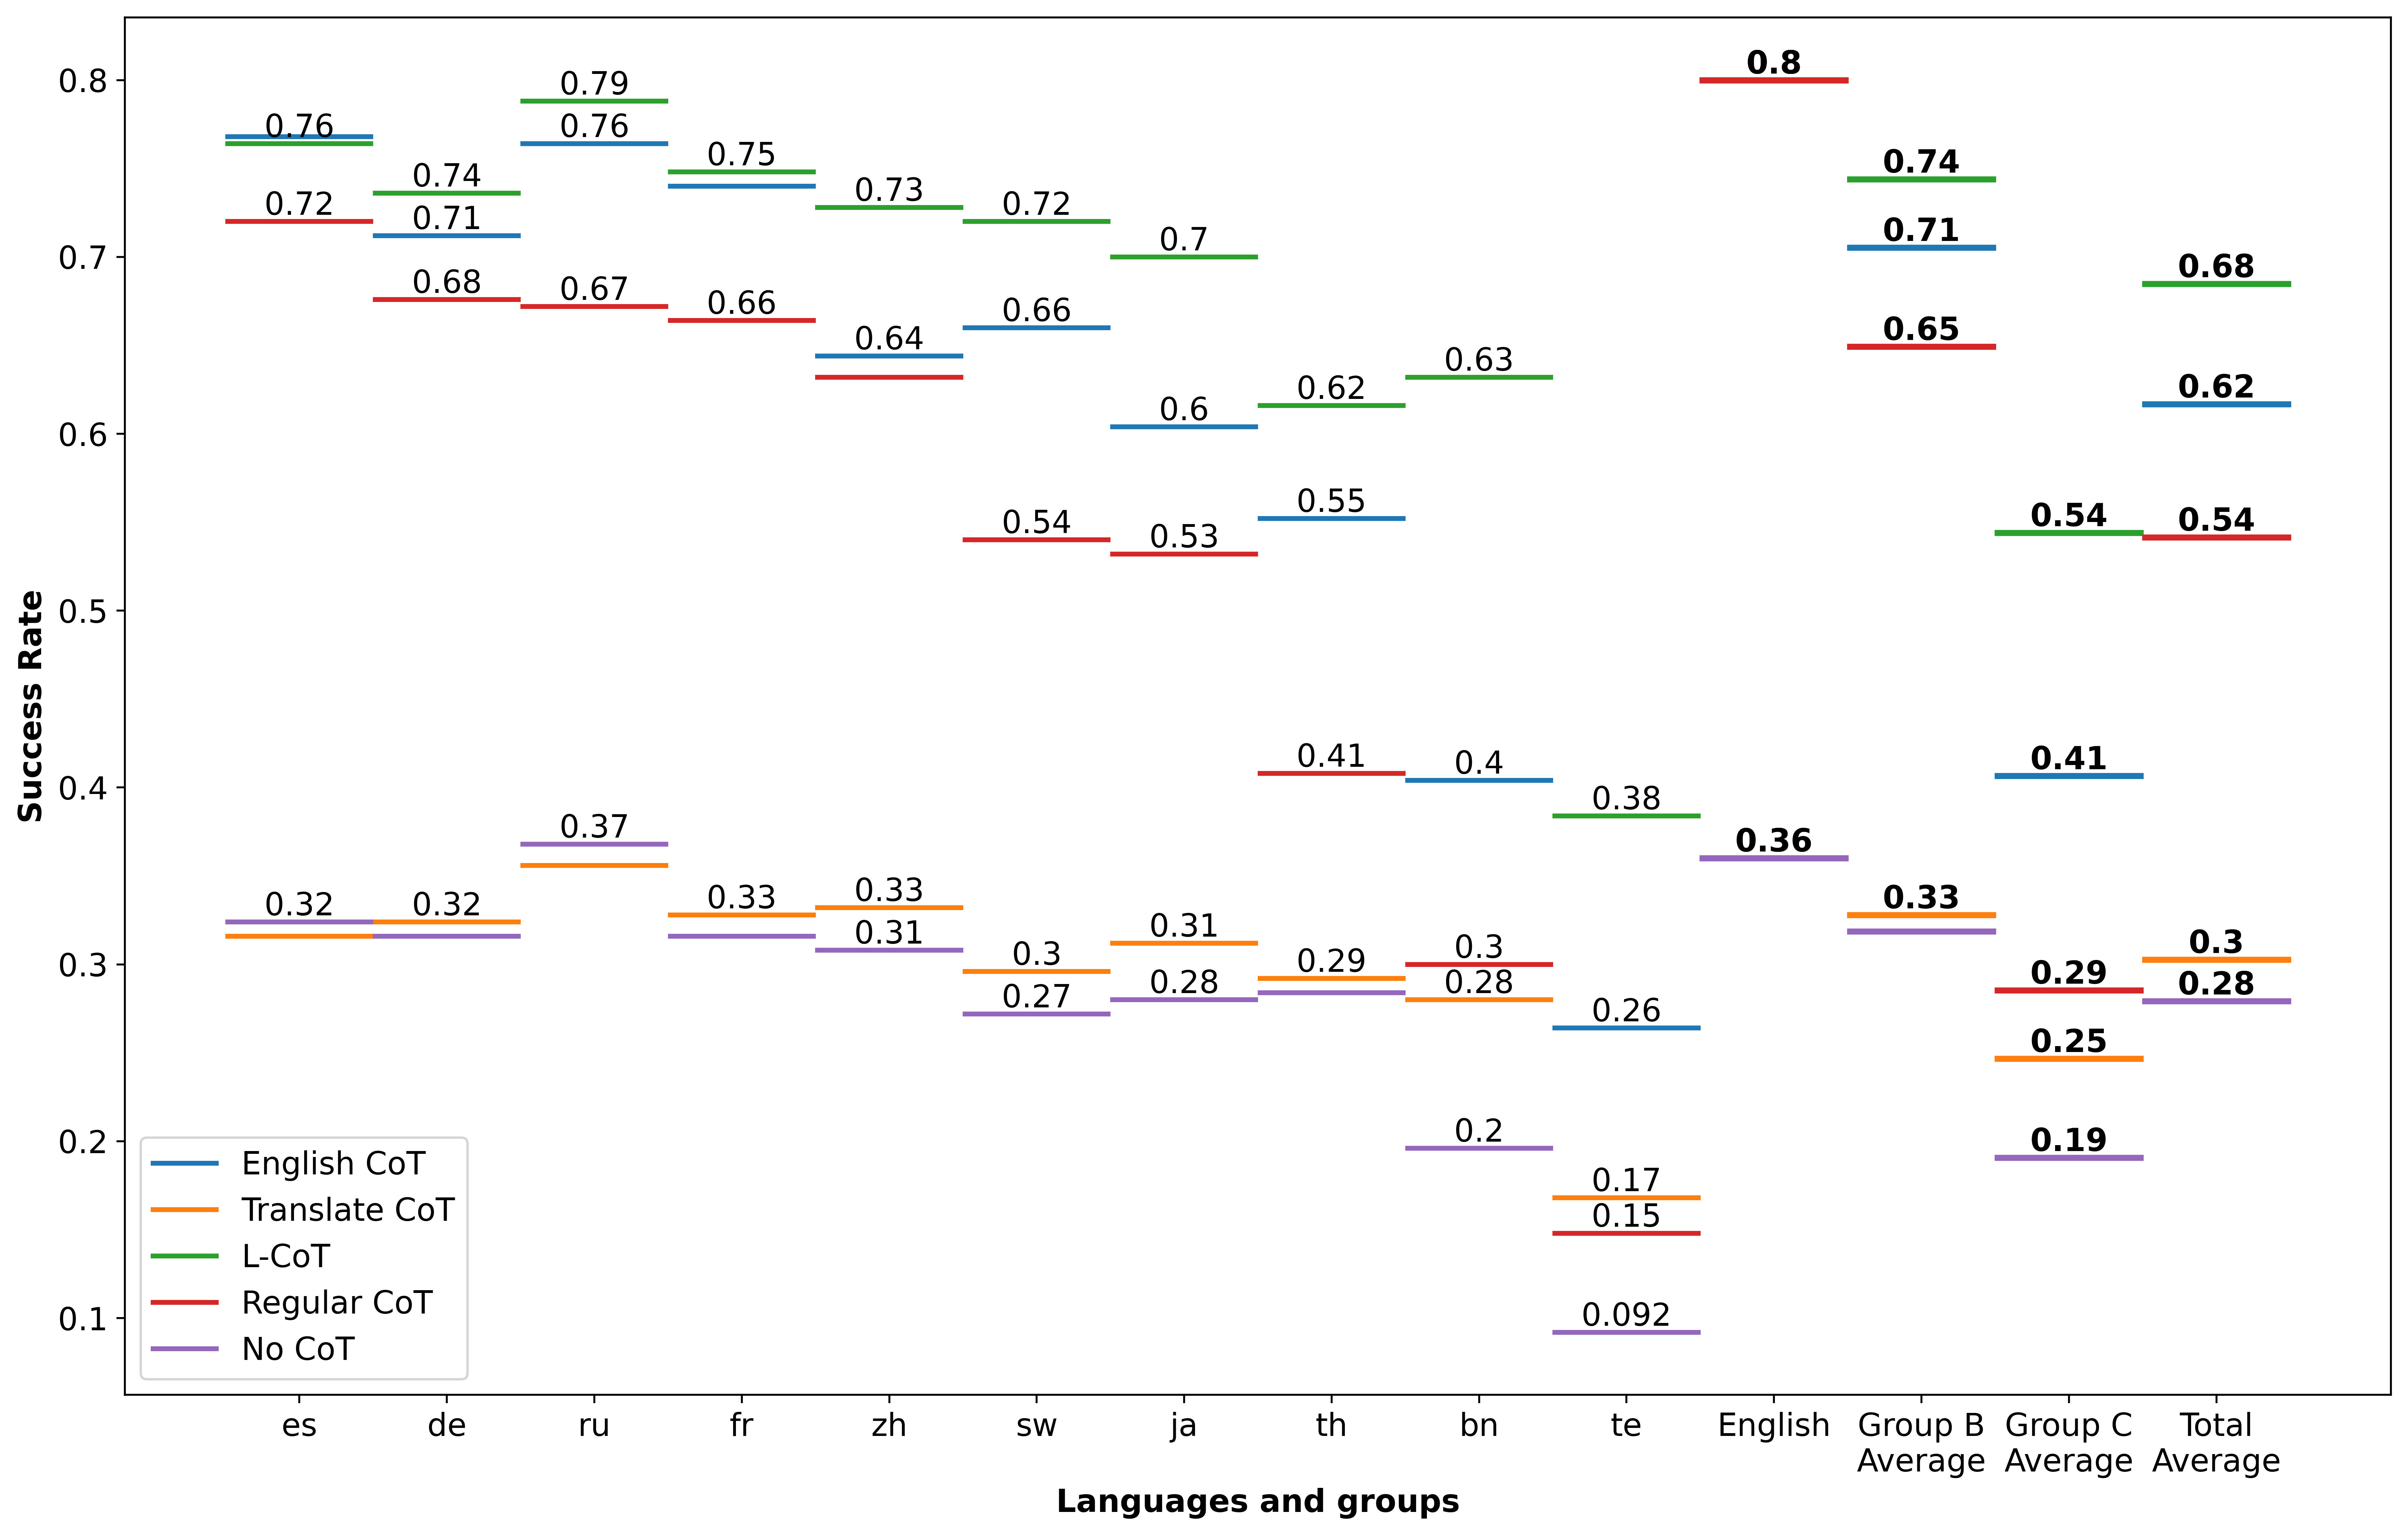

In [247]:
lan_to_show = new_col_names
LANGUAGE_TO_PLOT = lan_to_show
EXP_TO_PLOT = ['Column Language Question - English CoT','Translate without CoT Premise', 'L-COT','Column Language Question - Column Language CoT','(Forced) No COT']
EXP_NAMES_TO_SHOW = ['English CoT','Translate CoT','L-CoT','Regular CoT','No CoT']
X_TICKS  = ['es', 'de', 'ru', 'fr', 'zh', 'sw', 'ja', 'th', 'bn', 'te',"English",'Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ["English",'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "L-COT-GPT3.5"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 500
FIG_SIZE = (14,9)
FONT_SIZE = 13
Y_LIM = (None,None)
DROP_RESULT_FOR_VISUAL = [('es','Column Language Question - English CoT'),('de','(Forced) No COT'),('fr','(Forced) No COT'),('th','(Forced) No COT'),('Group B Average','(Forced) No COT'),
                         ('es','Translate without CoT Premise'),('ru','Translate without CoT Premise'),
                         ('fr','Column Language Question - English CoT'),('zh','Column Language Question - Column Language CoT')]
default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL)

## Fig 4.2 - Tokens Influence

In [259]:
results

es     de     ru     fr  \
(Forced) No COT                                  0.3240 0.3160 0.3680 0.3160   
Column Language Question - Column Language CoT   0.7200 0.6760 0.6720 0.6640   
Column Language Question - English CoT           0.7680 0.7120 0.7640 0.7400   
English Question - Column Language CoT           0.7760 0.7320 0.7240 0.7600   
Question in both languages - English CoT         0.7560 0.7680 0.7480 0.7800   
Question in both languages - Column Language CoT 0.7600 0.7280 0.7240 0.7000   
Translate without CoT Premise                    0.3160 0.3240 0.3560 0.3280   
L-COT                                            0.7640 0.7360 0.7880 0.7480   
No Premise (GPT-4o)                              0.7880 0.8000 0.8120 0.7400   
Regular CoT Premise (GPT-4o)                     0.8680 0.8440 0.8760 0.8120   
L-COT (GPT-4o)                                   0.9360 0.9160 0.9520 0.9000   

                                                     zh     sw     ja     th  \
(Forced) No COT                                  0.3080 0.2720 0.2800 0.2840   
Column Language Question - Column Language CoT   0.6320 0.5400 0.5320 0.4080   
Column Language Question - English CoT           0.6440 0.6600 0.6040 0.5520   
English Question - Column Language CoT           0.7400 0.7440 0.6880 0.6280   
Question in both languages - English CoT         0.7400 0.7760 0.7560 0.7480   
Question in both languages - Column Language CoT 0.7080 0.7040 0.6480 0.6440   
Translate without CoT Premise                    0.3320 0.2960 0.3120 0.2920   
L-COT                                            0.7280 0.7200 0.7000 0.6160   
No Premise (GPT-4o)                              0.8680 0.7560 0.8760 0.8360   
Regular CoT Premise (GPT-4o)                     0.8960 0.8880 0.8680 0.9240   
L-COT (GPT-4o)                                   0.9200 0.9120 0.8960 0.9240   

                                                     bn     te  English  \
(Forced) No COT                                  0.1960 0.0920   0.3600   
Column Language Question - Column Language CoT   0.3000 0.1480   0.8000   
Column Language Question - English CoT           0.4040 0.2640   0.8000   
English Question - Column Language CoT           0.4400 0.2560   0.7760   
Question in both languages - English CoT         0.7280 0.7240   0.7760   
Question in both languages - Column Language CoT 0.4880 0.2120   0.7760   
Translate without CoT Premise                    0.2800 0.1680   0.3600   
L-COT                                            0.6320 0.3840   0.8000   
No Premise (GPT-4o)                              0.8840 0.8680   0.8720   
Regular CoT Premise (GPT-4o)                     0.9120 0.8640   0.9520   
L-COT (GPT-4o)                                   0.9120 0.8880   0.9520   

                                                  Group B Average  \
(Forced) No COT                                            0.3187   
Column Language Question - Column Language CoT             0.6493   
Column Language Question - English CoT                     0.7053   
English Question - Column Language CoT                     0.7367   
Question in both languages - English CoT                   0.7580   
Question in both languages - Column Language CoT           0.7113   
Translate without CoT Premise                              0.3280   
L-COT                                                      0.7440   
No Premise (GPT-4o)                                        0.8140   
Regular CoT Premise (GPT-4o)                               0.8607   
L-COT (GPT-4o)                                             0.9200   

                                                  Group C Average  \
(Forced) No COT                                            0.1907   
Column Language Question - Column Language CoT             0.2853   
Column Language Question - English CoT                     0.4067   
English Question - Column Language CoT                     0.4413   
Question in both languages - English CoT                

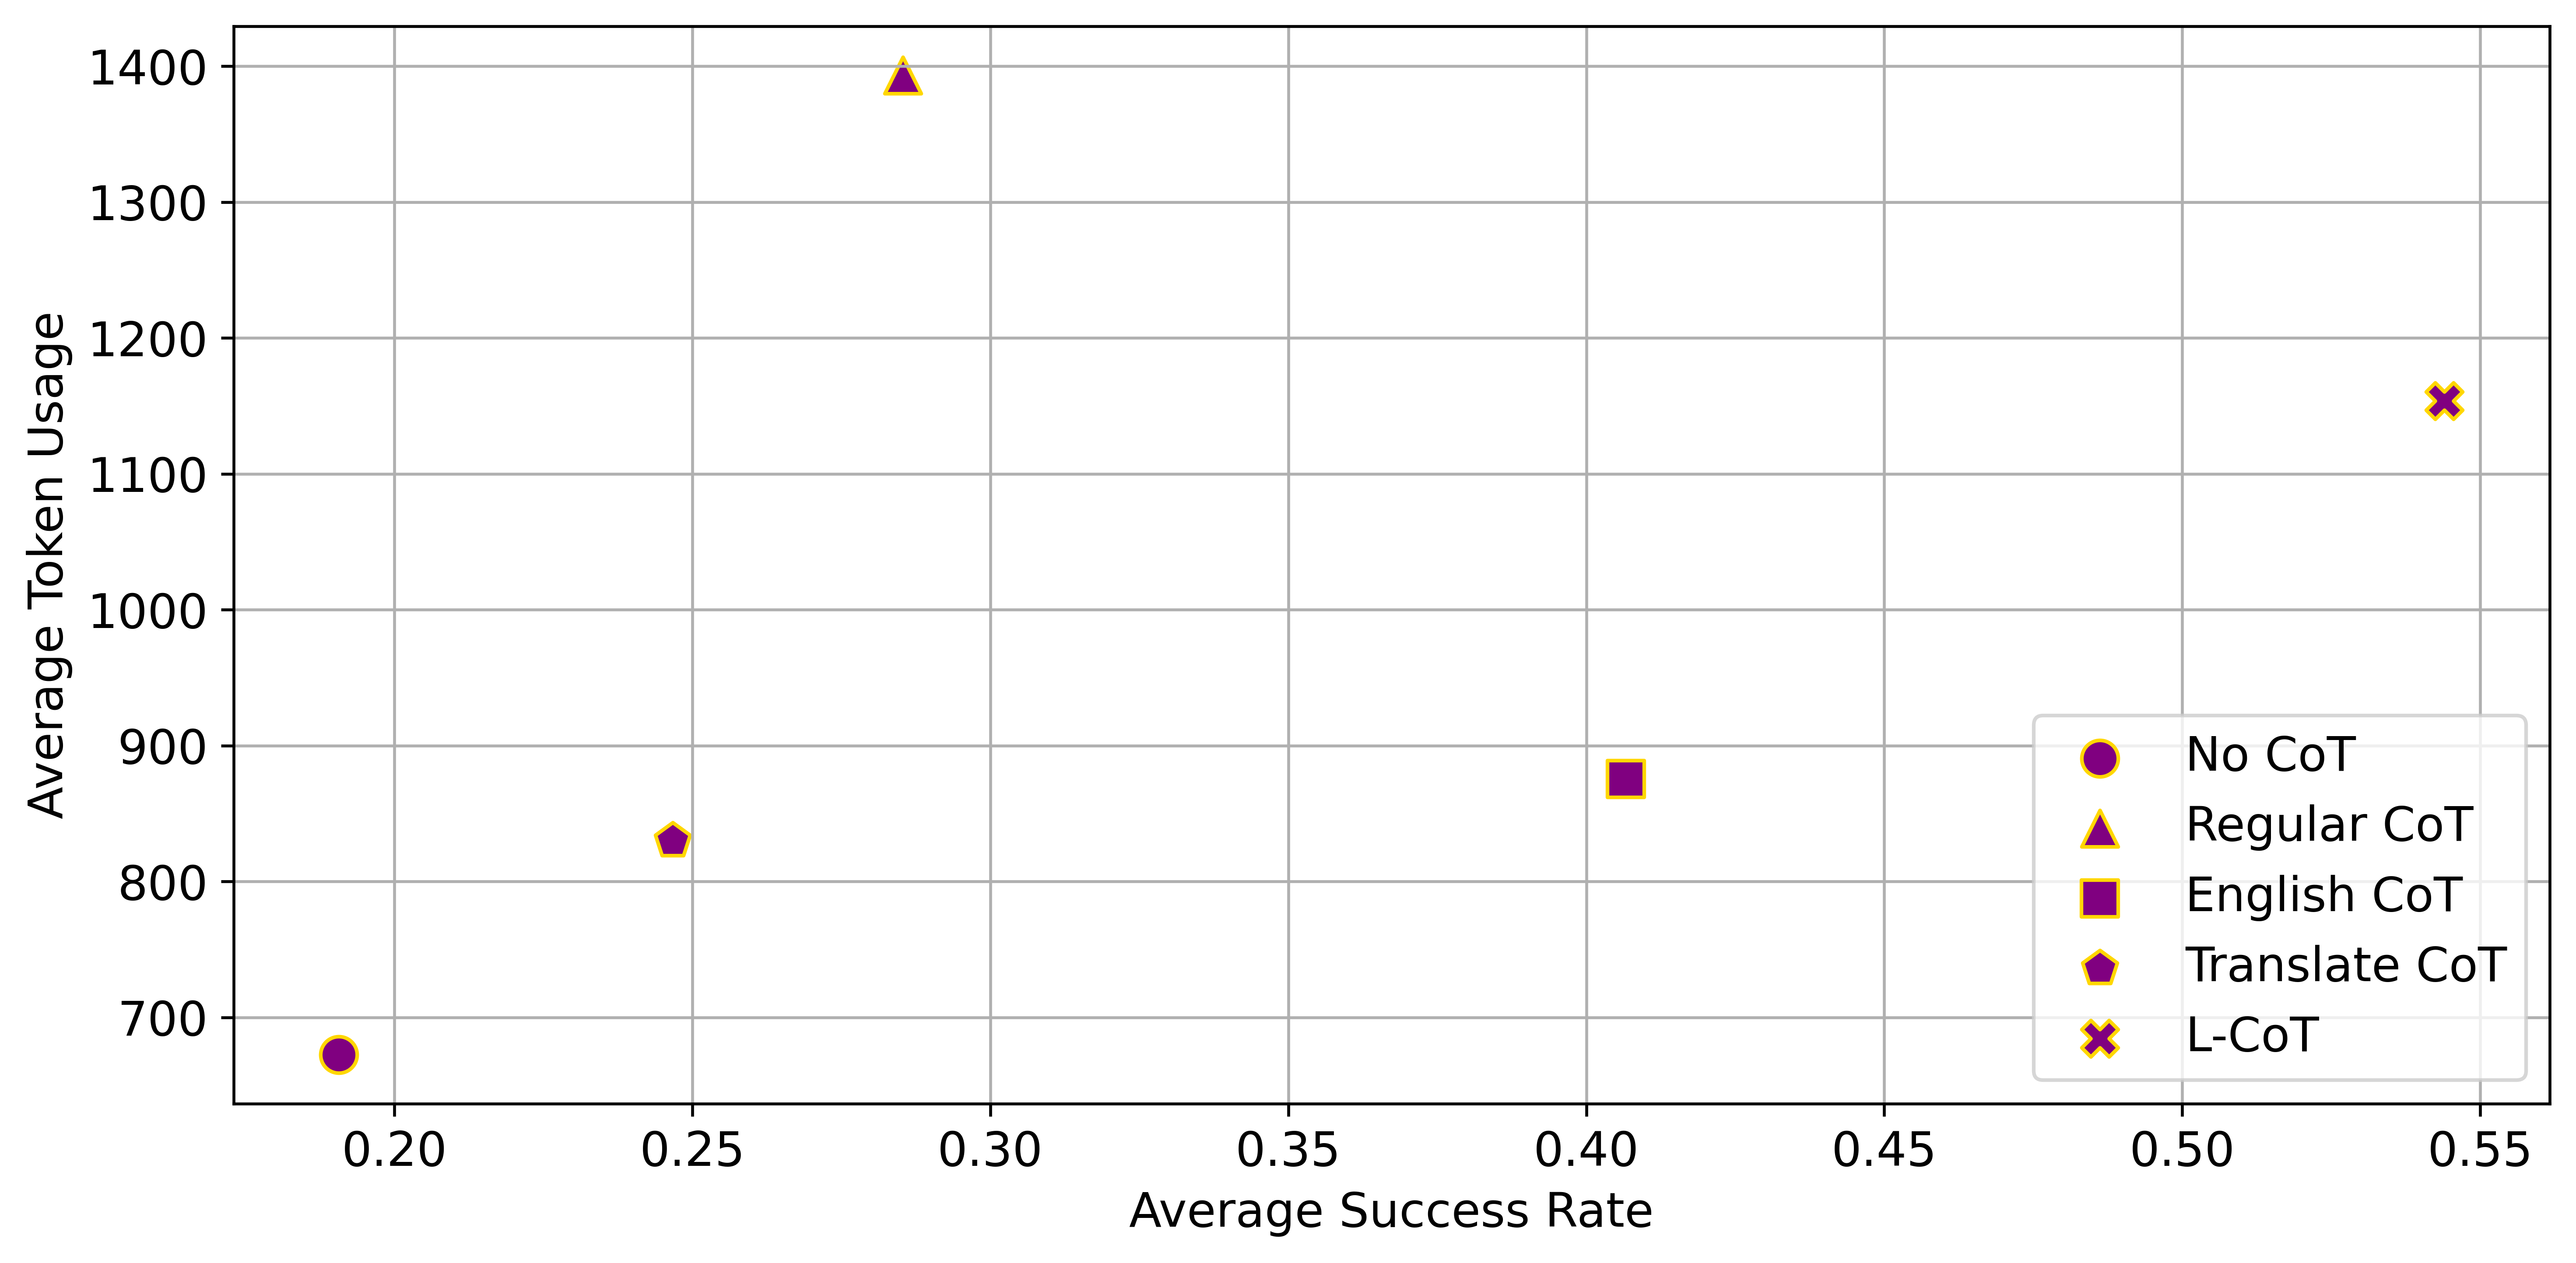

In [258]:
# Experiment 5 - tokens comparison (full tables in appendix)
import pandas as pd
import matplotlib.pyplot as plt
# EXP_TO_PLOT = ["Step-by-step COT","No COT","L-COT","English step-by-step COT"]
FIG_NAME = "Underrepresentted Languages - Success Rate and Tokens Usage (context tokens)"
EXP_TO_PLOT = ['(Forced) No COT','Column Language Question - Column Language CoT', 'Column Language Question - English CoT','Translate without CoT Premise', 'L-COT']
EXP_NAMES_TO_SHOW = ['No CoT','Regular CoT','English CoT','Translate CoT','L-CoT']
RES = 600
FIG_SIZE = (10, 5)
FONT_SIZE = 13
SAVE_PATH = f"graphs/{FIG_NAME}.png"
matplotlib.rcParams.update({'font.size': FONT_SIZE})

# Example data
data_x = results.loc[EXP_TO_PLOT,'Group C Average']
data_y = system_prompts_count_35.loc[EXP_TO_PLOT,'Group C Average']
exp_names = EXP_NAMES_TO_SHOW

# List of different markers for each point
markers = ['o', '^', 's', 'p','X']  # circle, triangle, square, pentagon

# Creating the scatter plot
plt.figure(figsize=FIG_SIZE,dpi= RES)  # Increasing the figure size to accommodate the legend outside

# Loop through each point and plot individually to use different markers
for i, (x, y) in enumerate(zip(data_x, data_y)):
    plt.scatter(x, y, color='purple', marker=markers[i], edgecolors='gold', s=100,
                label=f'{exp_names[i]}')  # Each point gets a label for the legend

# Adding customization
# plt.title('Underrepresentted Languages Success Rate and Tokens Usage')  # Title
plt.xlabel("Average Success Rate")  # X-axis label
plt.ylabel("Average Token Usage")  # Y-axis label
plt.grid(True)  # Adding a grid
# plt.xticks(data_x, fontsize=12)  # Customize x-ticks
# plt.yticks(fontsize=12)  # Customize y-ticks

# Add a legend outside of the plot
plt.legend(loc='lower right')

plt.tight_layout()  # Adjust layout to make room for the legend

if SAVE_PATH:
    plt.savefig(SAVE_PATH,dpi = RES)
plt.show()

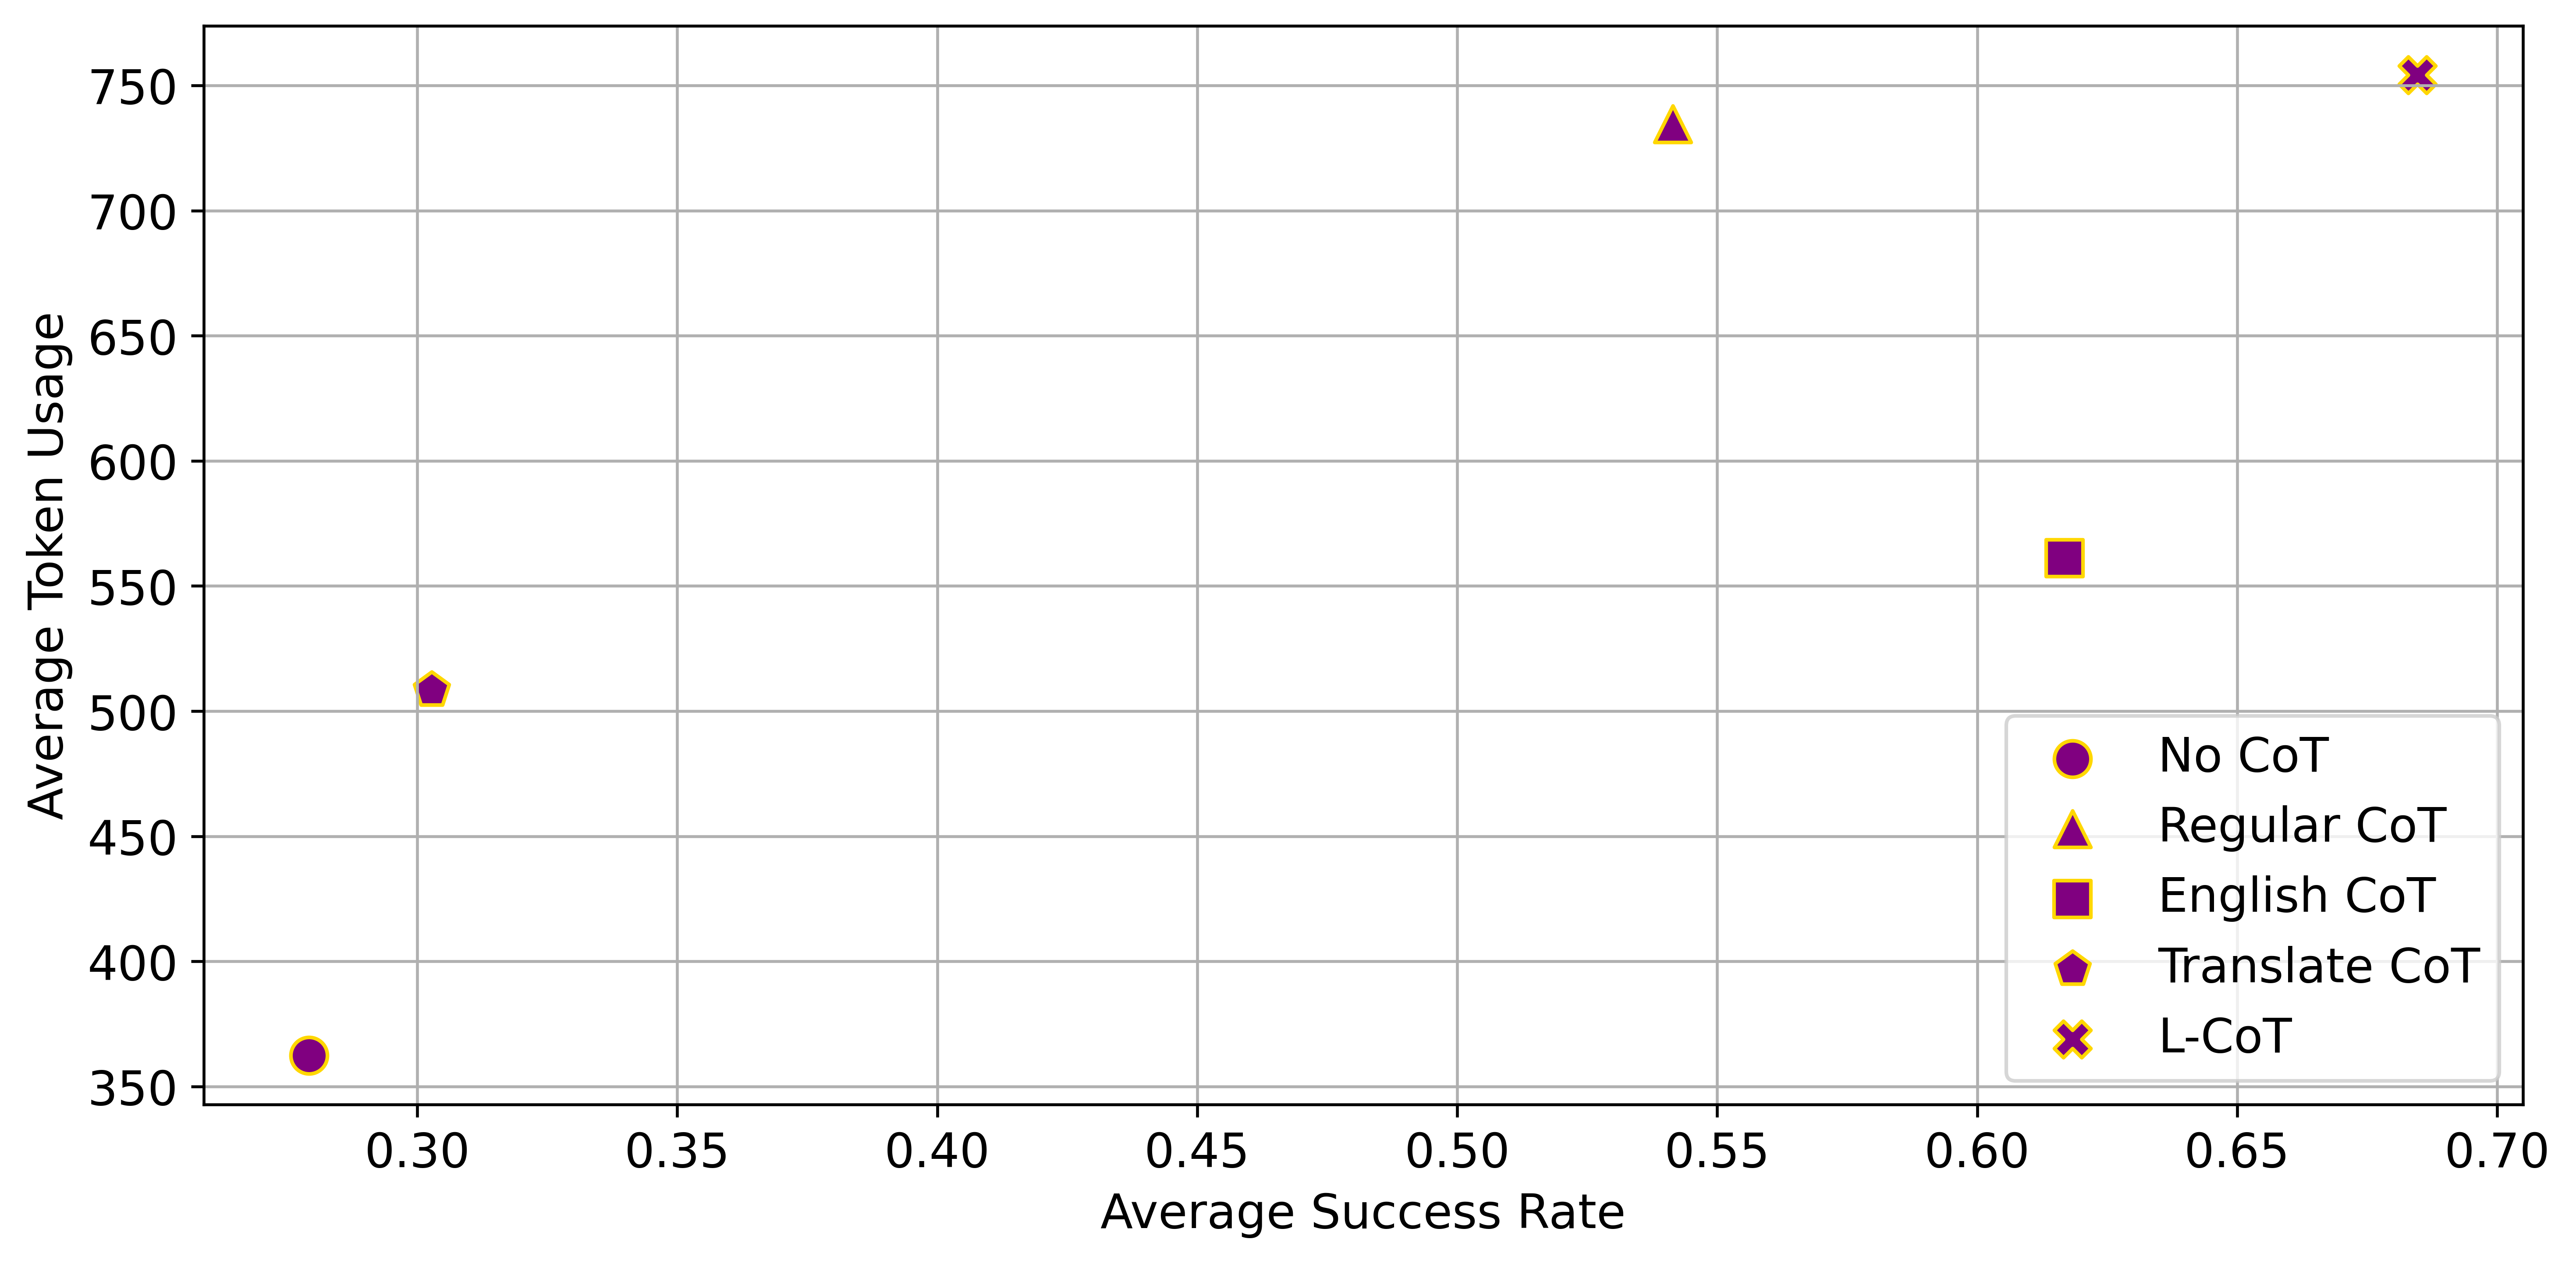

In [256]:
# Experiment 5 - tokens comparison - but on all data (full tables in appendix)
import pandas as pd
import matplotlib.pyplot as plt
# EXP_TO_PLOT = ["Step-by-step COT","No COT","L-COT","English step-by-step COT"]
FIG_NAME = "All Languages - Success Rate and Tokens Usage (context tokens)"
EXP_TO_PLOT = ['(Forced) No COT','Column Language Question - Column Language CoT', 'Column Language Question - English CoT','Translate without CoT Premise', 'L-COT']
EXP_NAMES_TO_SHOW = ['No CoT','Regular CoT','English CoT','Translate CoT','L-CoT']
RES = 600
FIG_SIZE = (10, 5)
FONT_SIZE = 13
SAVE_PATH = f"graphs/{FIG_NAME}.png"
matplotlib.rcParams.update({'font.size': FONT_SIZE})

# Example data
data_x = results.loc[EXP_TO_PLOT,'Total Average']
data_y = system_prompts_count_35.loc[EXP_TO_PLOT,'Total Average']
exp_names = EXP_NAMES_TO_SHOW

# List of different markers for each point
markers = ['o', '^', 's', 'p','X']  # circle, triangle, square, pentagon

# Creating the scatter plot
plt.figure(figsize=FIG_SIZE,dpi= RES)  # Increasing the figure size to accommodate the legend outside

# Loop through each point and plot individually to use different markers
for i, (x, y) in enumerate(zip(data_x, data_y)):
    plt.scatter(x, y, color='purple', marker=markers[i], edgecolors='gold', s=100,
                label=f'{exp_names[i]}')  # Each point gets a label for the legend

# Adding customization
# plt.title('Underrepresentted Languages Success Rate and Tokens Usage')  # Title
plt.xlabel("Average Success Rate")  # X-axis label
plt.ylabel("Average Token Usage")  # Y-axis label
plt.grid(True)  # Adding a grid
# plt.xticks(data_x, fontsize=12)  # Customize x-ticks
# plt.yticks(fontsize=12)  # Customize y-ticks

# Add a legend outside of the plot
plt.legend(loc='lower right')

plt.tight_layout()  # Adjust layout to make room for the legend

if SAVE_PATH:
    plt.savefig(SAVE_PATH,dpi = RES)
plt.show()

### Graph 4.3 - GPT 4o Main results

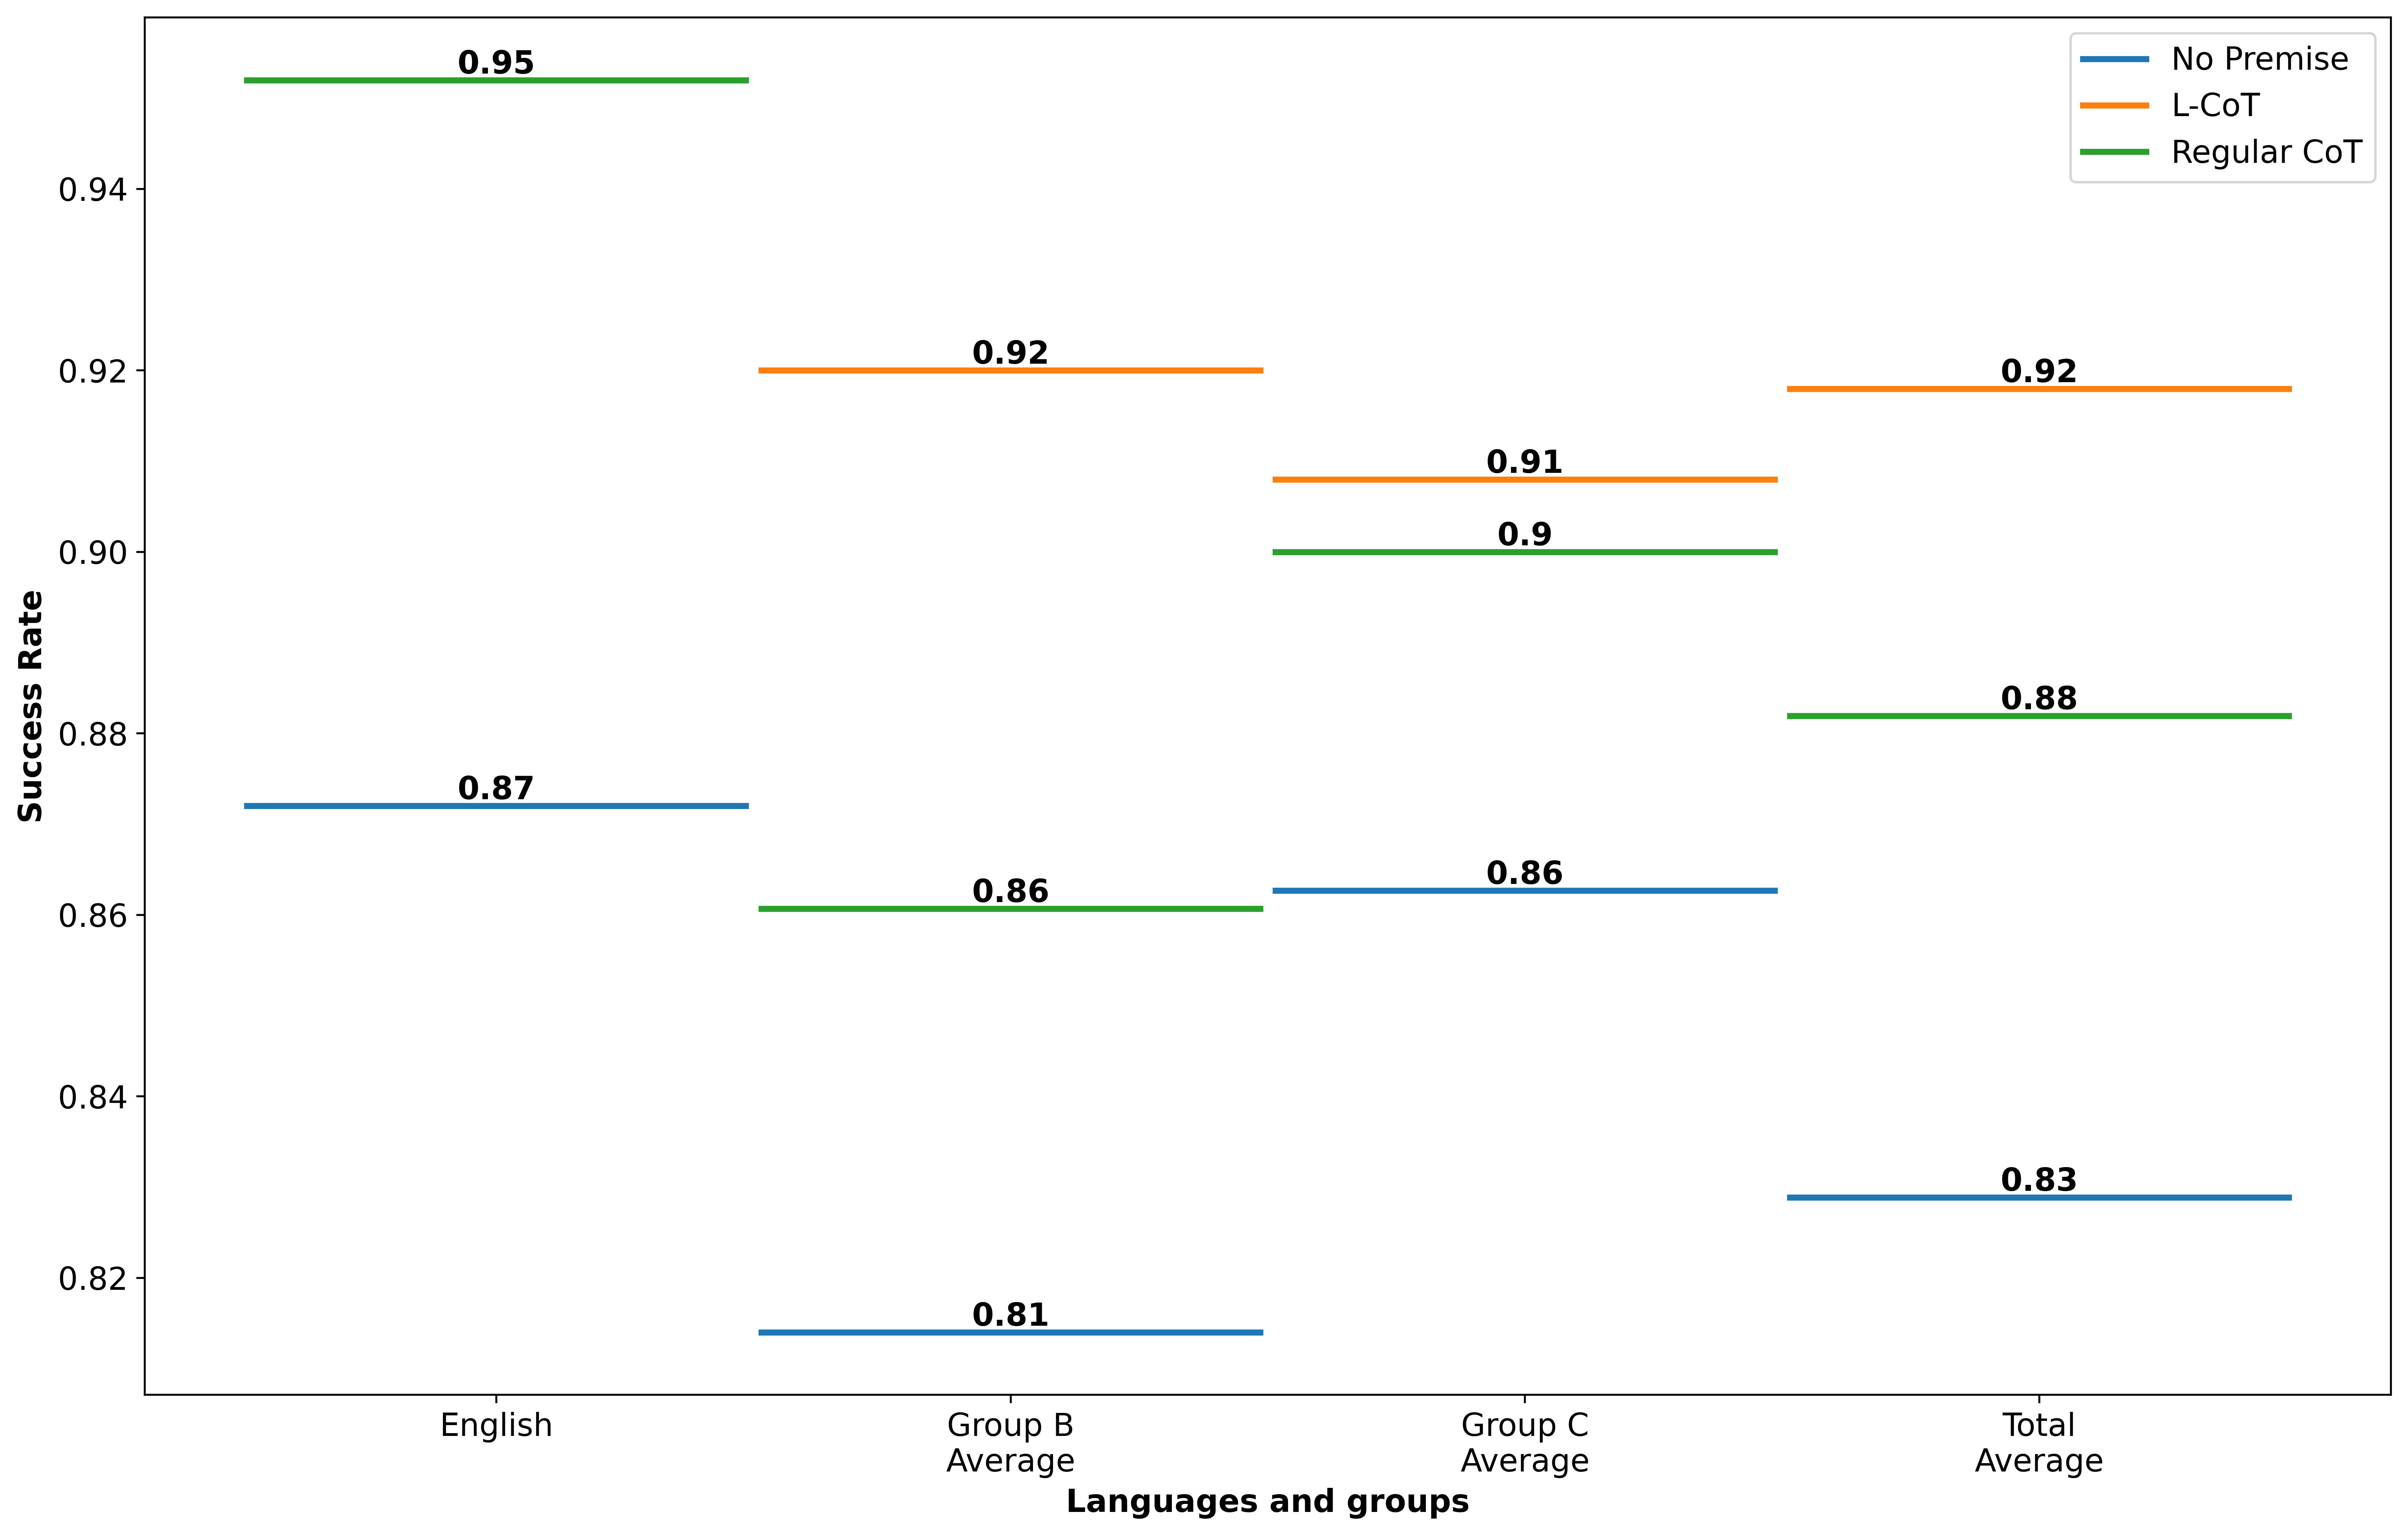

In [249]:
lan_to_show = ["English",'Group B Average', 'Group C Average', 'Total Average']
LANGUAGE_TO_PLOT = lan_to_show
EXP_TO_PLOT = ['No Premise (GPT-4o)', 'L-COT (GPT-4o)','Regular CoT Premise (GPT-4o)']
EXP_NAMES_TO_SHOW = ['No Premise','L-CoT','Regular CoT']
X_TICKS  = ["English",'Group B\nAverage','Group C\nAverage','Total\nAverage']
COLS_TO_BOLD = ["English",'Group B Average', 'Group C Average', 'Total Average']
FIG_NAME = "L-COT-GPT-4o"
SAVE_PATH = f"graphs/{FIG_NAME}.png"
RES = 500
FIG_SIZE = (14,9)
FONT_SIZE = 13
Y_LIM = (None,None)
DROP_RESULT_FOR_VISUAL = []
default_graph_creator(LANGUAGE_TO_PLOT,EXP_TO_PLOT,EXP_NAMES_TO_SHOW,X_TICKS,COLS_TO_BOLD,FIG_NAME,SAVE_PATH,RES,FIG_SIZE,Y_LIM,FONT_SIZE,DROP_RESULT_FOR_VISUAL)

### Compare to Other base models & CoT methods

In [238]:
models_results = [{"Name":'GPT 4o - OpenAI published results',"CoT Method": "Not specified", "Total Average": 0.905},
 {"Name":'GPT 4o - L-CoT',"CoT Method": "L-COT with n_shot = 3", "Total Average": 0.918},
 {"Name":'GPT 4o - Regular CoT',"CoT Method": "Regular CoT with n_shot = 3", "Total Average": 0.88},
 {"Name":'GPT 4o - without additional premise',"CoT Method": "no explicit CoT guidnace", "Total Average": 0.83},
 {"Name":'GPT 4 (original version)',"CoT Method": "Regular CoT with n_shot = 8", "Total Average": 0.745},
 {"Name":'PaLM 2',"CoT Method": "CoT, n_shot = 8, SC", "Total Average": 0.87},
 {"Name":'Calude 3 Opus',"CoT Method": "Not specified", "Total Average": 0.907},
 {"Name":'Gemini-1.5 pro',"CoT Method": "Regular CoT with n_shot = 8", "Total Average": 0.875},
 {"Name":'Gemini-1.0 ultra',"CoT Method": "Regular CoT with n_shot = 8", "Total Average": 0.79}]
 
pd.DataFrame(data = models_results).sort_values(by = 'Total Average',ascending = False)
# Say something about the face that it's challenging to compare because there are different models and CoT mehods,
# but here is a Comparison to the best we could find in the internet. Reference to this dataset is highly cited this year. 

Name                   CoT Method  \
1                       GPT 4o - L-CoT        L-COT with n_shot = 3   
6                        Calude 3 Opus                Not specified   
0    GPT 4o - OpenAI published results                Not specified   
2                 GPT 4o - Regular CoT  Regular CoT with n_shot = 3   
7                       Gemini-1.5 pro  Regular CoT with n_shot = 8   
5                               PaLM 2          CoT, n_shot = 8, SC   
3  GPT 4o - without additional premise     no explicit CoT guidnace   
8                     Gemini-1.0 ultra  Regular CoT with n_shot = 8   
4             GPT 4 (original version)  Regular CoT with n_shot = 8   

   Total Average  
1         0.9180  
6         0.9070  
0         0.9050  
2         0.8800  
7         0.8750  
5         0.8700  
3         0.8300  
8         0.7900  
4         0.7450